### Кластеризация

In [3]:
import pandas as pd
import numpy as np
from fuzzywuzzy import fuzz
import warnings
import os
earn_list = ['10100000000000000',
             '10300000000000000',
             '10500000000000000',
             '10600000000000000',
             '10700000000000000',
             '10800000000000000',
             '11200000000000000',
             '11300000000000000',
             '11400000000000000',
             '11600000000000000',
             '11700000000000000',
             '20000000000000000',
             '20200000000000000',
             '20210000000000150',
             '20215001000000150',
             '20220000000000150',

             'X']

cost_list = ['100',
             '200',
             '300',
             '400',
             '500',
             '600',
             '700',
             '800',
             '900',
             '1000',
             '1100',
             '1200',
             '1300',
             'х']

from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

##### Основной 2024 год
Из него возьмем таблицу scoring

In [4]:
vrp = pd.read_excel('VRP_s1998.xlsx', sheet_name='2')
original_names = [i.lower() for i in vrp.iloc[3:96, 0].to_list() if 'федеральный' not in i.lower().split(' ')]

vrp = vrp.reset_index(drop = True).fillna(0).set_axis(['name', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023'], axis = 1)
vrp.loc[:, 'name'] = vrp.loc[:, 'name'].apply(lambda x: str(x).lower())

vrp = vrp.set_index('name').loc[original_names,:]

years = {} # словарь куда будут складываться данные по годам

In [145]:
import pickle

# сохранить
with open("data_full.pkl", "wb") as f:
    pickle.dump(data, f)

# загрузить
with open("data_full.pkl", "rb") as f:
    data_loaded = pickle.load(f)

In [146]:
data_loaded

{'cost': {'gen_gov': {'exec':                                   2019      2020      2021      2022      2023
   белгородская область          0.525273  0.603338  0.452807  0.595992  0.579688
   брянская область              0.964782  1.033140  0.842113  0.878872  0.863811
   владимирская область          0.788262  0.838507  0.640487  0.908448  0.819773
   воронежская область           1.109763  1.022911  0.873390  0.972883  1.145374
   ивановская область            1.526496  1.445185  1.281231  1.267074  1.215538
   ...                                ...       ...       ...       ...       ...
   амурская область              1.506702  1.597258  1.447883  1.462686  1.209107
   магаданская область           1.562799  1.487752  1.510271  1.792908   1.74742
   сахалинская область           0.930718  1.151954  0.955520  0.863424  1.026412
   еврейская автономная область  2.635103  2.945370  2.364043   2.33792  2.172405
   чукотский автономный округ    2.721931  2.429091  2.275283   2.46237

In [5]:
# Получить путь к текущему .ipynb-файлу
notebook_path = os.path.abspath(".")

# Установить рабочую директорию к папке с файлами
os.chdir(notebook_path)
papka = 'cluster_data'
# Проверка
print("Текущая рабочая директория:", os.getcwd(), f'\nОттуда буду брать данные, там должна быть папка {papka} а в ней данные по годам')

path = notebook_path + f'\\{papka}' # провалимся в папку дата

list_with_years = os.listdir(path) # в папке дата лежит много папок по годам, используем их как список годов
year = list_with_years[-1]
list_with_files = os.listdir(path + f'\\{year}')

Текущая рабочая директория: c:\Users\vasil\YandexDisk\project\roskazna_2 
Оттуда буду брать данные, там должна быть папка cluster_data а в ней данные по годам


In [6]:
names = []
for file in list_with_files:
    df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= '0503317_Д')
    df = df.set_axis([i for i in range(df.shape[1])], axis=1)
    
    names += [df.iloc[4,3]+ ' ' + df.iloc[5,3]] # type: ignore



#cleaning before matching
tollerance_rate = 75
exc_list = ['-', '(', ')']
exc_list_types = ['министерств', 'республик', 'финансов', 'областн', 'бюджет', 'департамент', 'окружно', 'республиканск', 'области', 'по', 'областной',
            'автономно', 'округ', 'экономики', 'политики', 'город', 'муниципальн', 'образовани', 'город', 'управлени', 'правительств', 'в т.ч.', 'и',
            'комитет', 'государственн', 'главное', 'бюджетн', 'народной', 'финанс', 'края', 'имущественн', 'отношени', 'краево', 'контрол', 'край']
cleaned = []
for i in names:
    x = i.lower()
    for letter in exc_list:
        x = x.replace(letter, '')
    x = list(set(x.split(' ')))
    for j in exc_list_types:
        ratio_list = [(fuzz.token_set_ratio(i,j), i) for i in x]
        if len(ratio_list) != 0:
            max_tuple = max([(fuzz.token_set_ratio(i,j), i) for i in x])
            if max_tuple[0] > tollerance_rate:
                x.remove(max_tuple[1])
        else:
            continue

    cleaned = cleaned + [' '.join(x)]

original_names = [i.lower() for i in original_names]
original = []
for i in original_names:
    x = i.lower()
    for letter in exc_list:
        x = x.replace(letter, '')
    x = list(set(x.split(' ')))
    for j in exc_list_types:
        ratio_list = [(fuzz.token_set_ratio(i,j), i) for i in x]
        if len(ratio_list) != 0:
            max_tuple = max([(fuzz.token_set_ratio(i,j), i) for i in x])
            if max_tuple[0] > tollerance_rate:
                x.remove(max_tuple[1])
        else:
            continue
        
    original = original + [' '.join(x)]
    
tuples_list = [max([(fuzz.token_set_ratio(i,j),i, j) for j in cleaned]) for i in original]
scoring = pd.DataFrame(tuples_list, columns = ['score', 'original', 'cleaned'])
doubling = scoring.cleaned.value_counts().loc[(scoring.cleaned.value_counts() > 1).values].index.to_list()# type: ignore
drop = pd.DataFrame(columns = scoring.columns)
for i in range(len(doubling)):
    temp_df = scoring.loc[list(map(bool, (scoring == doubling[i]).sum(1).to_list())), :].sort_values(by = 'score', ascending = False)
    print(temp_df.iloc[0,:].to_list())
    drop = pd.concat([drop if not drop.empty else None, temp_df.iloc[1:,:]])
scoring = scoring.loc[[i not in drop.original.to_list() for i in scoring.original.to_list()],:].copy()
wrong_guesses = {k:[v] for k, v in zip(drop.original.to_list(), drop.cleaned.to_list())}
counter = 0
while counter < 100:
    tuples_list = []
    for w_g in wrong_guesses.keys():
        pos_guesses = cleaned.copy()
        for not_p_g in wrong_guesses[w_g]:
            pos_guesses.remove(not_p_g)
        tuples_list = tuples_list + [max([(fuzz.token_set_ratio(w_g,j),w_g, j) for j in pos_guesses])]
    scoring = pd.concat([scoring, pd.DataFrame(tuples_list, columns = ['score', 'original', 'cleaned'])])
    
    # break point
    if sum((scoring.cleaned.value_counts() > 1).values) == 0:
        break

    doubling = scoring.cleaned.value_counts().loc[(scoring.cleaned.value_counts() > 1).values].index.to_list() # type: ignore
    drop = pd.DataFrame(columns = scoring.columns)
    for i in range(len(doubling)):
        temp_df = scoring.loc[list(map(bool, (scoring == doubling[i]).sum(1).to_list())), :].sort_values(by = 'score', ascending = False)
        print(temp_df.iloc[0,:].to_list())
        drop = pd.concat([drop if not drop.empty else None, temp_df.iloc[1:,:]])
    scoring = scoring.loc[[i not in drop.original.to_list() for i in scoring.original.to_list()],:].copy()
    drop = {k:[v] for k, v in zip(drop.original.to_list(), drop.cleaned.to_list())}
    wrong_guesses_new = {}
    for w_g in drop.keys():
        try:
            wrong_guesses_new[w_g] = wrong_guesses[w_g] + drop[w_g]
        except:
            wrong_guesses_new[w_g] = drop[w_g]
    wrong_guesses = wrong_guesses_new.copy()
    counter = counter + 1
scoring = scoring.reset_index(drop = True).copy()
if scoring.cleaned.unique().shape == scoring.original.unique().shape:
    print("Нет пропущенных регионов")
else:
    print("Есть пропущенные регионы")

scoring['original_names'] = original_names
scoring['names'] = '0'
for i in range(scoring.shape[0]):
    region = scoring.loc[i, 'cleaned']
    iteration_index = 0
    for n in cleaned:
        
        if region == n:
            scoring.loc[i, 'names'] = names[iteration_index]
        iteration_index += 1  

Нет пропущенных регионов


### 2024 год

In [7]:
year = list_with_years[-1]
list_with_files = os.listdir(path + f'\\{year}')

files_regions = {}
year_dict = {'earn':[], 'cost':[]}
for file in list_with_files:
    df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= '0503317_Д')
    df = df.set_axis([i for i in range(df.shape[1])], axis=1)
    

    try:
        name = scoring.query(f'names == "{df.iloc[4,3]+ ' ' + df.iloc[5,3]}"').loc[:, 'original_names'].item()# type: ignore
        files_regions[file.split('_')[0]] = name
    except:
        print(f'Не неайден "{df.iloc[4,3]+ ' ' + df.iloc[5,3]}"') # type: ignore
        continue
    
    
    plan_index = df.isin(['Утвержденные бюджетные назначения']).sum(1)[df.isin(['Утвержденные бюджетные назначения']).sum(1) == 1].index.item()
    plan_col = df.isin(['Утвержденные бюджетные назначения']).sum(0)[df.isin(['Утвержденные бюджетные назначения']).sum(0) == 1].index.item()
    res_index = df.isin(['Исполнено']).sum(1)[df.isin(['Исполнено']).sum(1) == 1].index.item()
    res_col = df.isin(['Исполнено']).sum(0)[df.isin(['Исполнено']).sum(0) == 1].index.item()

    region_earn_res = df.iloc[res_index:, res_col-2:]
    region_earn_plan = df.iloc[plan_index:, plan_col-2:res_col-2]
    region_dict = {'name':name}
    for code in earn_list:
        try:
            if code == "X":

                index_value = region_earn_res.loc[region_earn_res.fillna(0).loc[:,res_col-2].copy().isin([f'{code}']).to_list()].index.item() # type: ignore
                region_dict[code] = {'Исполнено':region_earn_res.loc[index_value, res_col]}
                region_dict[code]['Утверждено'] = region_earn_plan.loc[index_value, plan_col] if region_earn_plan.loc[index_value, plan_col] != 0 else region_earn_res.loc[index_value, res_col]# type: ignore
            else: # специально для москвы, самары и перми
                index_value =region_earn_res.loc[[j == code[:-3] for j in [i[:-3] for i in region_earn_res.fillna(0).loc[:,res_col-1].astype(int).astype(str).to_list()]]].index.item()# type: ignore

                region_dict[code] = {'Исполнено':region_earn_res.loc[index_value, res_col]}
                region_dict[code]['Утверждено'] = region_earn_plan.loc[index_value, plan_col] if region_earn_plan.loc[index_value, plan_col] != 0 else region_earn_res.loc[index_value, res_col] # type: ignore           

        except:
                print(f"Нет кода: {code}, в доходах")
    
    year_dict['earn'] += [region_dict]

    df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= '0503317_Р')
    df = df.set_axis([i for i in range(df.shape[1])], axis=1).fillna(0)



    plan_index = df.isin(['Утвержденные бюджетные назначения']).sum(1)[df.isin(['Утвержденные бюджетные назначения']).sum(1) == 1].index.item()
    plan_col = df.isin(['Утвержденные бюджетные назначения']).sum(0)[df.isin(['Утвержденные бюджетные назначения']).sum(0) == 1].index.item()
    res_index = df.isin(['Исполнено']).sum(1)[df.isin(['Исполнено']).sum(1) == 1].index.item()
    res_col = df.isin(['Исполнено']).sum(0)[df.isin(['Исполнено']).sum(0) == 1].index.item()

    region_cost_res = df.iloc[res_index:, res_col-4:]
    region_cost_plan = df.iloc[plan_index:, plan_col-4:res_col-4]


    region_dict = {'name':name}
    for code in cost_list:
        try:
            if code == 'х':
                index_value = region_cost_res.loc[region_cost_res.loc[:,res_col-4].isin([code])].index[0].item() # type: ignore
                region_dict[code] = {'Исполнено':region_cost_res.loc[index_value, res_col]}
                region_dict[code]['Утверждено'] = region_cost_plan.loc[index_value, plan_col]
            else:

                index_value = [i and j for i , j in zip(region_cost_res.loc[:,res_col-3].astype(int).astype(str).copy().isin([f'{code}']).to_list( # type: ignore

                ), region_cost_res.loc[:,res_col-1].astype(int).astype(str).copy().isin(['0']).to_list())] # type: ignore
                index_value = region_cost_res.loc[index_value].index.item()
                region_dict[code] = {'Исполнено':region_cost_res.loc[index_value, res_col]}
                region_dict[code]['Утверждено'] = region_cost_plan.loc[index_value, plan_col]
        except:
            print(f"Нет кода: {code}, в расходах")
    
    year_dict['cost'] += [region_dict]
    years[year] = year_dict

Не неайден "МИНИСТЕРСТВО ФИНАНСОВ ЗАПОРОЖСКОЙ ОБЛАСТИ Бюджет Запорожской области"
Не неайден "АДМИНИСТРАЦИЯ ФЕДЕРАЛЬНОЙ ТЕРРИТОРИИ "СИРИУС" Бюджет федеральной территории "Сириус""
Не неайден "МИНИСТЕРСТВО ФИНАНСОВ ДОНЕЦКОЙ НАРОДНОЙ РЕСПУБЛИКИ Бюджет Донецкой Народной Республики"
Не неайден "МИНИСТЕРСТВО ФИНАНСОВ ЛУГАНСКОЙ НАРОДНОЙ РЕСПУБЛИКИ Бюджет Луганской Народной Республики"
Не неайден "Межрегиональное операционное управление Федерального казначейства Сводный отчет по консолидированным бюджетам субъектов Российской Федерации и территориальным государственным внебюджетным фондам"
Не неайден "УПРАВЛЕНИЕ ФИНАНСОВ АДМИНИСТРАЦИИ ГОРОДА БАЙКОНУР Бюджет города Байконур"
Не неайден "МИНИСТЕРСТВО ФИНАНСОВ ХЕРСОНСКОЙ ОБЛАСТИ Бюджет Херсонской области"


In [8]:
for year in list_with_years[:-1]:

    print(f'{'-'*50} \n Год {year}\n{'-'*50}')

    list_with_files = os.listdir(path + f'\\{year}')

    year_dict = {'earn':[], 'cost':[]}
    for file in list_with_files:
        try:
            df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= '0503317_Д')
        except:
            df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= 'стр.1_2')
        df = df.set_axis([i for i in range(df.shape[1])], axis=1).fillna(0)
        
        f_code = file.split('_')[0]
        try:
            list(files_regions.keys()).index(f_code)
        except:
            print(f'Не неайден "{df.iloc[4,3]+ ' ' + df.iloc[5,3]}"') # type: ignore
            continue


        name = files_regions[f_code]
        
        
        plan_index = df.isin(['Утвержденные бюджетные назначения']).sum(1)[df.isin(['Утвержденные бюджетные назначения']).sum(1) == 1].index.item()
        plan_col = df.isin(['Утвержденные бюджетные назначения']).sum(0)[df.isin(['Утвержденные бюджетные назначения']).sum(0) == 1].index.item()
        res_index = df.isin(['Исполнено']).sum(1)[df.isin(['Исполнено']).sum(1) == 1].index.item()
        res_col = df.isin(['Исполнено']).sum(0)[df.isin(['Исполнено']).sum(0) == 1].index.item()

        region_earn_res = df.iloc[res_index:, res_col-2:]
        region_earn_plan = df.iloc[plan_index:, plan_col-2:res_col-2]
        region_dict = {'name':name}
        for code in earn_list:
            try:
                if code == "X":

                    index_value = region_earn_res.loc[region_earn_res.fillna(0).loc[:,res_col-2].copy().isin([f'{code}']).to_list()].index.item() # type: ignore
                    region_dict[code] = {'Исполнено':region_earn_res.loc[index_value, res_col]}
                    region_dict[code]['Утверждено'] = region_earn_plan.loc[index_value, plan_col] if region_earn_plan.loc[index_value, plan_col] != 0 else region_earn_res.loc[index_value, res_col] # type: ignore
                else: # специально для москвы, самары и перми
                    index_value =region_earn_res.loc[[j == code[:-3] for j in [i[:-3] for i in region_earn_res.fillna(0).loc[:,res_col-1].astype(int).astype(str).to_list()]]].index.item() # type: ignore

                    region_dict[code] = {'Исполнено':region_earn_res.loc[index_value, res_col]}
                    region_dict[code]['Утверждено'] = region_earn_plan.loc[index_value, plan_col] if region_earn_plan.loc[index_value, plan_col] != 0 else region_earn_res.loc[index_value, res_col] # type: ignore         

            except:
                    print(f"{name}: нет кода: {code}, в доходах")
        
        year_dict['earn'] += [region_dict]

        try:
            df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= '0503317_Р')
        except:
            df = pd.read_excel(path + f'\\{year}' + f'\\{file.lower()}', engine='xlrd', sheet_name= 'стр.3_4')
        df = df.set_axis([i for i in range(df.shape[1])], axis=1).fillna(0)



        plan_index = df.isin(['Утвержденные бюджетные назначения']).sum(1)[df.isin(['Утвержденные бюджетные назначения']).sum(1) == 1].index.item()
        plan_col = df.isin(['Утвержденные бюджетные назначения']).sum(0)[df.isin(['Утвержденные бюджетные назначения']).sum(0) == 1].index.item()
        res_index = df.isin(['Исполнено']).sum(1)[df.isin(['Исполнено']).sum(1) == 1].index.item()
        res_col = df.isin(['Исполнено']).sum(0)[df.isin(['Исполнено']).sum(0) == 1].index.item()

        region_cost_res = df.iloc[res_index:, res_col-4:]
        region_cost_plan = df.iloc[plan_index:, plan_col-4:res_col-4]


        region_dict = {'name':name}
        for code in cost_list:
            try:
                if code == 'х':
                    index_value = region_cost_res.loc[region_cost_res.loc[:,res_col-4].isin([code])].index[0].item() # type: ignore
                    region_dict[code] = {'Исполнено':region_cost_res.loc[index_value, res_col]}
                    region_dict[code]['Утверждено'] = region_cost_plan.loc[index_value, plan_col]
                else:

                    index_value = [i and j for i , j in zip(region_cost_res.loc[:,res_col-3].astype(int).astype(str).copy().isin([f'{code}']).to_list(

                    ), # type: ignore
                                                            region_cost_res.loc[:,res_col-1].astype(int).astype(str).copy().isin(['0']).to_list())]# type: ignore
                    index_value = region_cost_res.loc[index_value].index.item()
                    region_dict[code] = {'Исполнено':region_cost_res.loc[index_value, res_col]}
                    region_dict[code]['Утверждено'] = region_cost_plan.loc[index_value, plan_col]
            except:
                print(f"{name}: нет кода: {code}, в расходах")
        
        year_dict['cost'] += [region_dict]
        years[year] = year_dict

-------------------------------------------------- 
 Год 2019
--------------------------------------------------
г.москва: нет кода: 20215001000000150, в доходах
г.севастополь: нет кода: 200, в расходах
г.севастополь: нет кода: 1300, в расходах
Не неайден "Межрегиональное операционное управление Федерального казначейства Федеральный бюджет"
Не неайден "УПРАВЛЕНИЕ ФИНАНСОВ АДМИНИСТРАЦИИ ГОРОДА БАЙКОНУР Бюджет Управления финансов администрации города Байконур"
-------------------------------------------------- 
 Год 2020
--------------------------------------------------
г.москва: нет кода: 20215001000000150, в доходах
г.севастополь: нет кода: 200, в расходах
г.севастополь: нет кода: 1300, в расходах
Не неайден "Межрегиональное операционное управление Федерального казначейства СВОДНЫЙ отчет по консолидированным бюджетам субъектов Российской Федерации и территориальным государственным внебюджетным фондам"
Не неайден "УПРАВЛЕНИЕ ФИНАНСОВ АДМИНИСТРАЦИИ ГОРОДА БАЙКОНУР Бюджет Управления фина

In [9]:
earn_list_names = [
    'income_tax',
    'goods_tax',
    'gen_income_tax',
    'property_tax',
    'resourse_tax',
    'gov_fees',
    'polution_tax',
    'gov_service',
    'sells',
    'gov_penalties',
    'rest_income',
    'all_grants',
    'mbt',
    'donat',
    'donat_rbo',
    'subsidies',
    'total'
]
earn_list_names = {k: v for k, v in zip(earn_list, earn_list_names)}

cost_list_names = [
    'gen_gov',
    'military',
    'n_security',
    'n_economy',
    'zhkh',
    'env_protect',
    'education',
    'culture',
    'health_care',
    's_policy',
    'sport',
    'smi',
    'debt',
    'total'
]

cost_list_names = {k:v for k, v in zip(cost_list, cost_list_names)}

In [10]:
data = {}
iter_dict = {'cost':cost_list_names, 'earn':earn_list_names}
for type_ in iter_dict:
    dict_of_a_codes = {}
    for code in iter_dict[type_]:
        dict_of_years = {}
        for year in list_with_years:
            dict_of_regions = {}
            for sample in years[year][type_]:
                try:
                    dict_of_regions[sample['name']] = sample[code]
                except:
                    dict_of_regions[sample['name']] = {'Исполнено': None, 'Утверждено': None}
                    print(f'{"-"*50}\n{sample['name']}, год {year}, код {code}\n{"-"*50} пропущен')
            dict_of_years[year] = dict_of_regions
        
        df_exec = pd.DataFrame(dict_of_years)
        for col in df_exec.columns:
            df_exec[col] = df_exec[col].apply(lambda x: x['Исполнено'])
        df_exec = df_exec.iloc[[list(df_exec.index).index(i) for i in vrp.rename_axis(None, axis=0).index], :-1].copy()
        df_exec = df_exec/(vrp.iloc[:, 3:]*10000)

        df_plan = pd.DataFrame(dict_of_years)
        for col in df_plan.columns:
            df_plan[col] = df_plan[col].apply(lambda x: x['Утверждено'])
        df_plan = df_plan.iloc[[list(df_plan.index).index(i) for i in vrp.rename_axis(None, axis=0).index], :-1].copy()
        df_plan = df_plan/(vrp.iloc[:, 3:]*10000)

        dict_of_years = {'exec': df_exec, 'plan': df_plan}

        dict_of_a_codes[iter_dict[type_][code]] = dict_of_years # type: ignore
    
    data[type_] = dict_of_a_codes

--------------------------------------------------
г.севастополь, год 2019, код 200
-------------------------------------------------- пропущен
--------------------------------------------------
г.севастополь, год 2020, код 200
-------------------------------------------------- пропущен
--------------------------------------------------
г.севастополь, год 2021, код 200
-------------------------------------------------- пропущен
--------------------------------------------------
г.севастополь, год 2019, код 1300
-------------------------------------------------- пропущен
--------------------------------------------------
г.севастополь, год 2020, код 1300
-------------------------------------------------- пропущен
--------------------------------------------------
г.севастополь, год 2021, код 1300
-------------------------------------------------- пропущен
--------------------------------------------------
г.севастополь, год 2022, код 1300
------------------------------------------------

In [11]:
criteria_1 = data['earn']['donat']['exec']/data['earn']['mbt']['exec'] # доля дотаций в мбт
criteria_1_p = data['earn']['donat']['plan']/data['earn']['mbt']['plan'] # доля дотаций в мбт
criteria_2 = data['earn']['total']['exec']/data['cost']['total']['exec'] # дефицит (в виде отношения доходов к расходам. Иначе очень сильно падает качество разбиения)
criteria_2_p = data['earn']['total']['plan']/data['cost']['total']['plan'] # дефицит (в виде отношения доходов к расходам. Иначе очень сильно падает качество разбиения)
criteria_3 = ((vrp.iloc[:, 3:]/vrp.iloc[:, :-3].to_numpy())**(1/4)).rename_axis(None, axis = 0) # type: ignore
criteria_3_p = ((vrp.iloc[:, 2:-1]/vrp.iloc[:, :-3].to_numpy())**(1/3)).rename_axis(None, axis = 0) # type: ignore
own_income = (data['earn']['income_tax']['exec'] 
              +data['earn']['property_tax']['exec']
              +data['earn']['goods_tax']['exec'])
criteria_4 = own_income/data['earn']['total']['exec'] # доля собственных доходов в общих
own_income_p = (data['earn']['income_tax']['plan'] 
              +data['earn']['property_tax']['plan']
              +data['earn']['goods_tax']['plan'])
criteria_4_p = own_income/data['earn']['total']['plan'] # доля собственных доходов в общих
social_costs = (data['cost']['culture']['exec']+
              data['cost']['education']['exec']+
              data['cost']['sport']['exec']+
              data['cost']['s_policy']['exec']+
              data['cost']['health_care']['exec'])
criteria_5 = social_costs/data['cost']['total']['exec'] # доля социальных расходов во всех доходах
criteria_6 = (data['earn']['total']['exec'] - data['cost']['total']['exec']) # обычный дефицит
criteria_7 = (data['earn']['total']['plan'] - data['cost']['total']['plan']) # планируемый дефицит
criteria_8 = (data['cost']['debt']['exec'] - data['cost']['debt']['plan'])


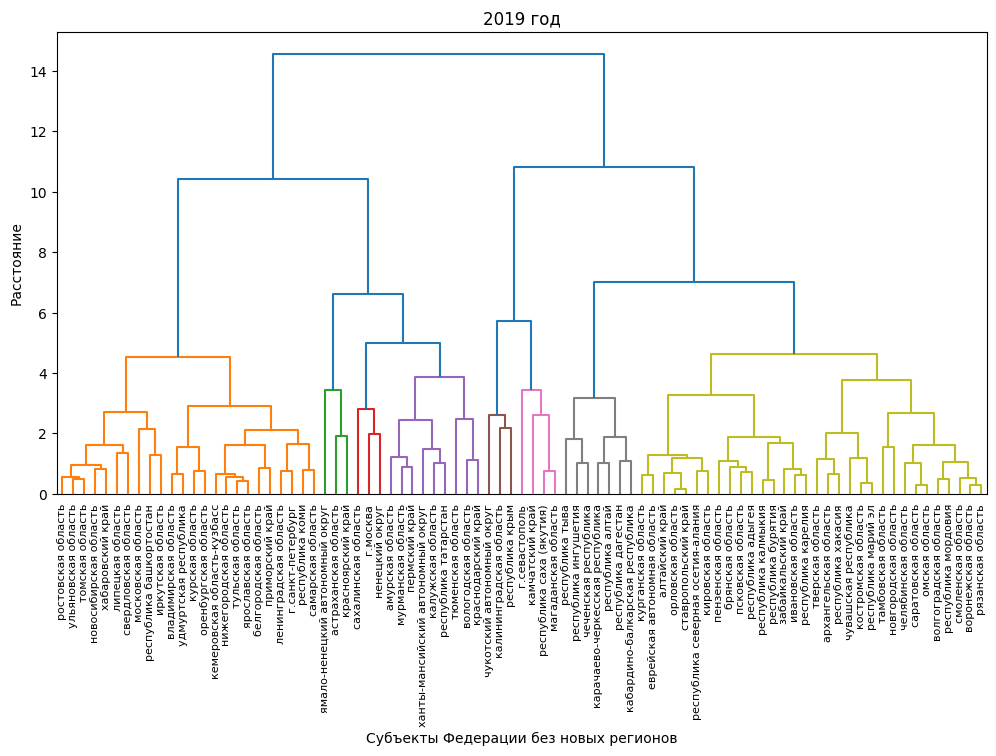

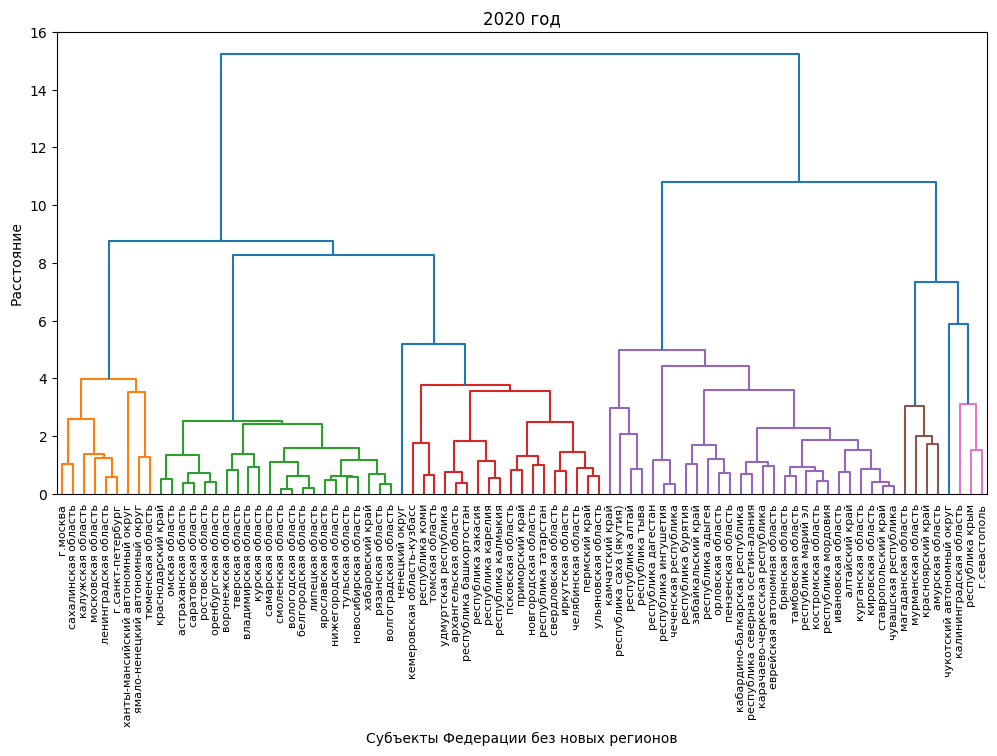

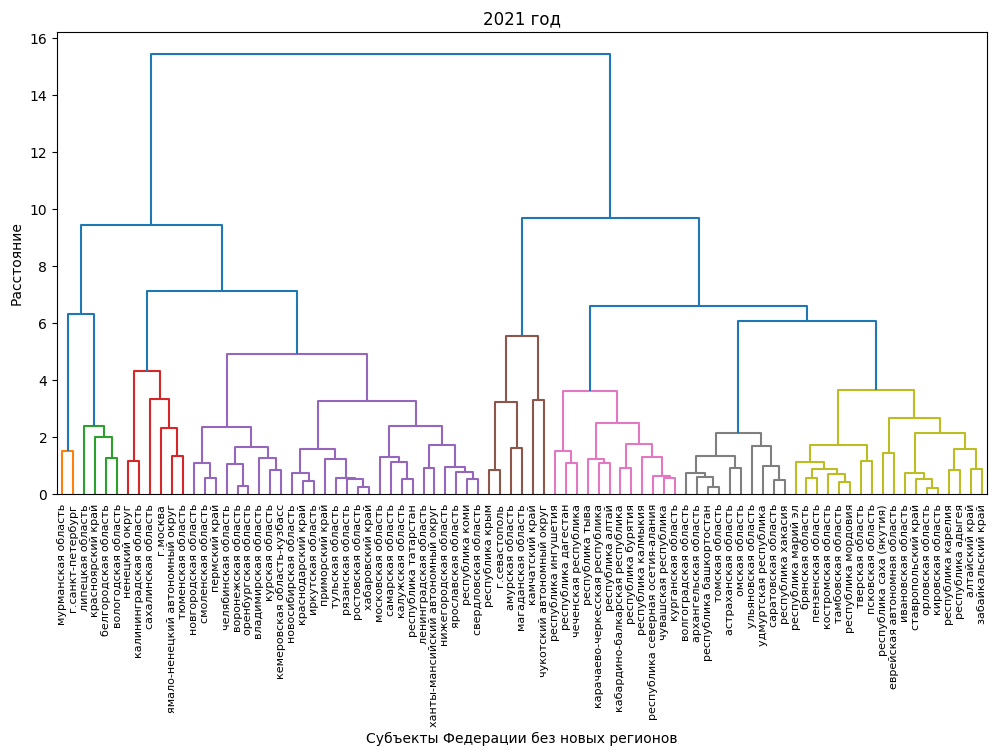

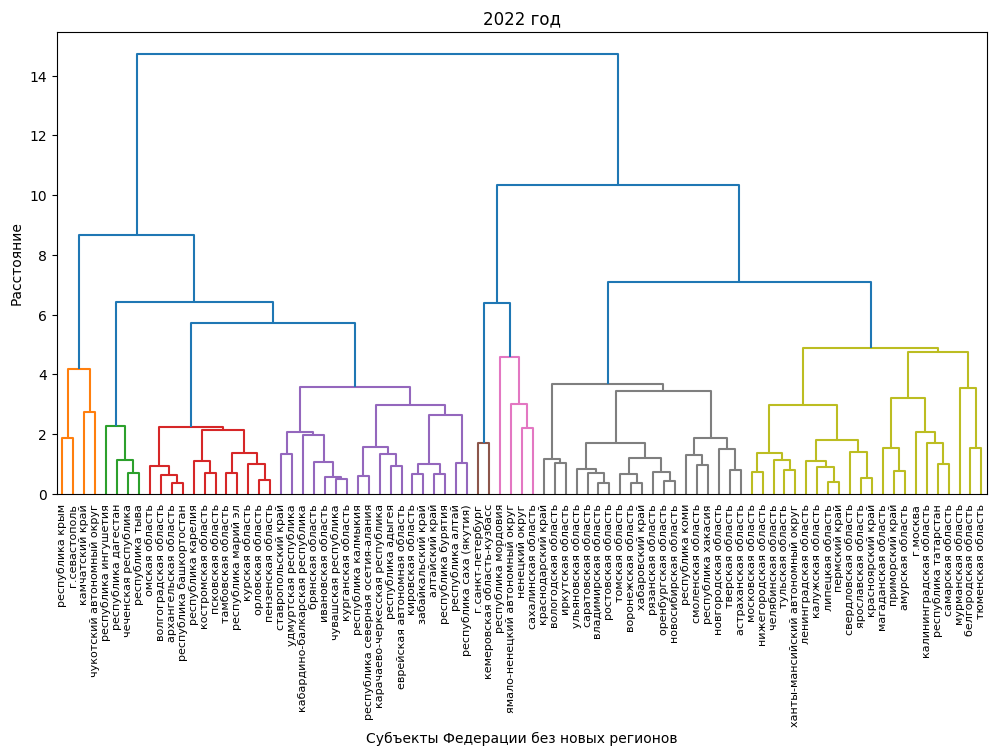

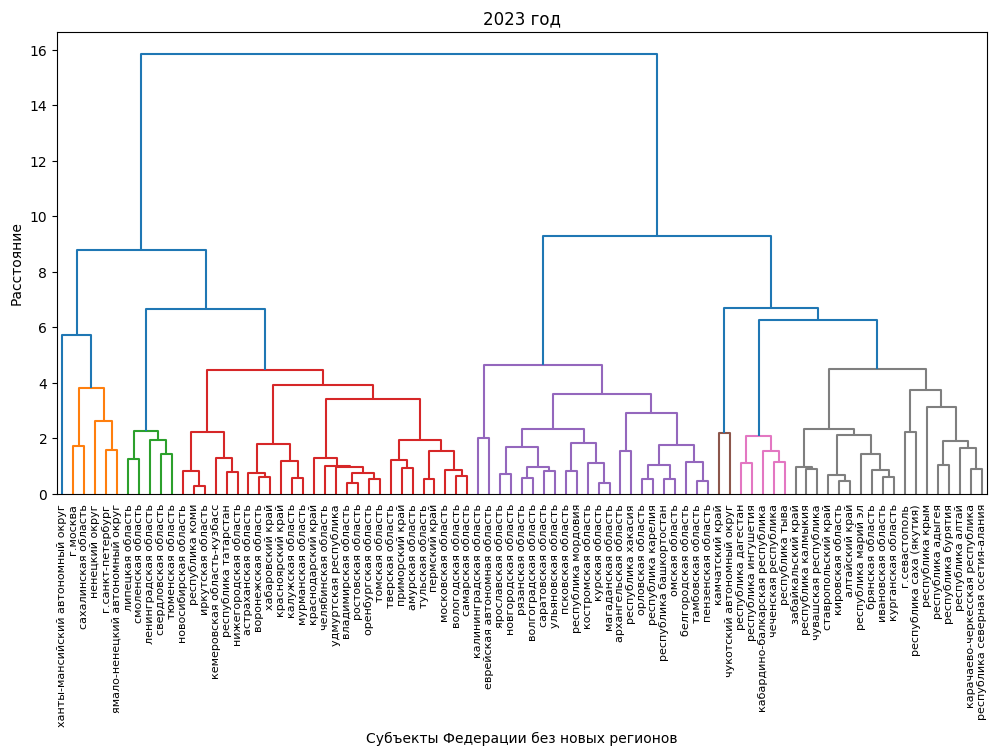

Средняя ARI по годам 0.32194625710110536


In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

list_of_years = ['2019', '2020', '2021', '2022', '2023']
all_labels = pd.DataFrame()  # сюда будем собирать метки

for year in list_of_years:

    cluster_data = pd.DataFrame([criteria_1[year], 
                                criteria_2[year], 
                                criteria_3[year],
                                criteria_4[year],
                                criteria_5[year]]).T
    cluster_data.columns = ['cr_1','cr_2','cr_3','cr_4','cr_5']
    
    # стандартизируем
    cluster_data = cluster_data.apply(lambda x: (x - np.mean(x))/np.std(x))
    
    # иерархическая кластеризация
    Z = linkage(cluster_data.values, method="ward")
    
    # разбиение на 5 кластеров
    labels = fcluster(Z, t=5, criterion='maxclust')
    
    # добавляем в таблицу
    all_labels[year] = labels

    # (опционально) рисуем дендрограмму
    plt.figure(figsize=(12,6))
    dendrogram(
        Z,
        labels=cluster_data.index.astype(str),
        leaf_rotation=90,
        leaf_font_size=8,
        color_threshold=Z[-7, 2]
    )
    plt.title(f"{year} год")
    plt.xlabel("Субъекты Федерации без новых регионов")
    plt.ylabel("Расстояние")
    plt.show()

# выводим таблицу меток
n_years = len(list_of_years)
# матрица сходства между всеми запусками
ari_matrix = np.zeros((n_years, n_years))
for i in range(n_years):
    for j in range(i+1, n_years):
        ari = adjusted_rand_score(all_labels.iloc[:, i], all_labels.iloc[:, j])
        ari_matrix[i, j] = ari
        ari_matrix[j, i] = ari
ari_matrix[np.triu_indices(n_years, 1)].mean()
print(f"Средняя ARI по годам {ari_matrix[np.triu_indices(n_years, 1)].mean()}")


Похоже на 4 или 5 кластеров. Нет постоянства по годам, поэтому сделаем ход конем. Поскольку в каждом критерии берем z-score начальные точки не будут зависеть от года. Поэтому для каждой симуляции найдем ARI между годами (средняя из сочитания 1 из 5) и внутригрупповую дисперсию. Будем выбирать симуляцию, которая дает наиболее устойчивое между годами распределение с поправкой на внутригрупповую дисперсию

In [14]:
nc = 5
n_runs = 10000
ari_list = []
n_years = len(list_of_years)
list_of_sims = []
vars_ = []
for i in range(n_runs):
    sim = []
    var_list = []
    for year in list_of_years:
        cluster_data = pd.DataFrame([criteria_1[year], 
                                    criteria_2[year], 
                                    criteria_3[year],
                                    criteria_4[year],
                                    criteria_5[year]]).T.set_axis([
                    'cr_1', 'cr_2', 'cr_3', 'cr_4', 'cr_5'
                ], axis=1)
        X = cluster_data.apply(lambda x: (x - np.mean(x))/np.std(x))
        km = KMeans(n_clusters=nc, init="random", n_init=1, random_state=i)
        labels = km.fit_predict(X)
        sim.append(labels)
        cluster_data.loc[:, 'cluster'] = labels
        var_list.append(sum([cluster_data.query(f'cluster == {i}').iloc[:, :-1].var(0).sum() for i in range(nc)]))

    # матрица сходства между всеми запусками
    ari_matrix = np.zeros((n_years, n_years))

    for i in range(n_years):
        for j in range(i+1, n_years):
            ari = adjusted_rand_score(sim[i], sim[j])
            ari_matrix[i, j] = ari
            ari_matrix[j, i] = ari
    ari_list.append(ari_matrix[np.triu_indices(n_years, 1)].mean())
    list_of_sims.append(sim)
    vars_.append(np.mean(var_list))
searching_df = pd.DataFrame([ari_list, vars_]).T.set_axis(['ari', 'varience'], axis=1).sort_values('ari', ascending=False)
print(f"Среднее ARI: {np.mean(ari_list).round(3)}\n"
      f"Нижний дециль {np.quantile(ari_list, q = 0.1).round(3)}\n"
      f"Верхний дециль {np.quantile(ari_list, q = 0.9).round(3)}\n"
      f"Симуляция с самым устойчивым разбиением: {ari_list.index(max(ari_list))}, ARI {max(ari_list)}")


Среднее ARI: 0.312
Нижний дециль 0.247
Верхний дециль 0.39
Симуляция с самым устойчивым разбиением: 8675, ARI 0.5604677049713351


In [17]:
SIM = ari_list.index(max(ari_list))
vars_[SIM], np.quantile(vars_, 0.9), np.mean(vars_)

(np.float64(0.12496492340704819),
 np.float64(0.1412926860728666),
 np.float64(0.1269637986911152))

Получается, что самое лучшее разбиение все равно так или иначе вариация разбиения на два, а это значит, что кластеризация по-большому счету бессмыслена.

In [18]:
list_of_sims[8675]

[array([0, 4, 0, 0, 4, 1, 4, 0, 0, 1, 4, 0, 0, 4, 0, 0, 0, 1, 4, 0, 1, 0,
        0, 3, 1, 0, 0, 4, 1, 4, 4, 3, 0, 2, 0, 0, 3, 4, 4, 4, 4, 4, 4, 4,
        0, 4, 0, 1, 0, 4, 0, 4, 0, 0, 4, 0, 0, 0, 4, 0, 1, 2, 2, 0, 4, 4,
        0, 4, 2, 0, 0, 0, 0, 0, 4, 4, 4, 4, 0, 0, 0, 4, 1, 4, 3],
       dtype=int32),
 array([2, 4, 2, 2, 4, 1, 4, 2, 2, 1, 4, 2, 2, 4, 2, 2, 2, 1, 2, 2, 0, 2,
        2, 3, 1, 2, 2, 2, 1, 4, 4, 3, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4,
        2, 4, 4, 2, 2, 4, 2, 4, 2, 2, 4, 2, 2, 2, 4, 2, 1, 1, 1, 2, 4, 4,
        2, 4, 2, 2, 2, 2, 2, 2, 4, 4, 4, 3, 2, 2, 3, 3, 1, 4, 3],
       dtype=int32),
 array([0, 4, 2, 2, 4, 1, 4, 2, 0, 1, 4, 2, 2, 4, 2, 2, 2, 1, 4, 2, 1, 2,
        0, 3, 1, 0, 2, 4, 1, 4, 4, 3, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4,
        2, 4, 4, 1, 2, 4, 2, 4, 2, 2, 4, 1, 2, 2, 4, 2, 1, 1, 1, 2, 4, 4,
        2, 4, 0, 2, 2, 2, 2, 2, 4, 4, 4, 3, 2, 2, 3, 3, 2, 4, 3],
       dtype=int32),
 array([1, 4, 2, 2, 4, 2, 2, 4, 1, 1, 4, 2, 2, 4, 2, 1, 2, 1, 4, 2, 0, 2,

In [20]:

results = []

for year in list_of_years:
    cluster_data = pd.DataFrame([criteria_1[year], 
                                criteria_2[year], 
                                criteria_3[year],
                                criteria_4[year],
                                criteria_5[year]]).T.set_axis([
                'Доля дотаций в МБТ', 
                'Соотношение совокупных доходов к совокупным расходам', 
                'Средний темп роста номинального ВРП за последние три года',
                'Доля собственных доходов в доходах', 
                'Доля социальных расходов в совокупных расходах'
            ], axis=1)
    cluster_data['cluster'] = list_of_sims[SIM][list_of_years.index(year)]
    results += [cluster_data.groupby("cluster").agg(["mean", "std", "min", "max", "count"])]

results.append(pd.DataFrame(list_of_sims[SIM]).T.set_axis(list_of_years, axis = 1).set_axis(vrp.index, axis = 0))


In [21]:
with pd.ExcelWriter("output.xlsx") as writer:
    for df, sheet in zip(results, list_of_years + ['Разбиение']):
        df.to_excel(writer, sheet_name=sheet, index=True)

In [22]:
SIM = 8675
nc = 5
centers = []
for year in list_of_years:
    cluster_data = pd.DataFrame([criteria_1[year], 
                                criteria_2[year], 
                                criteria_3[year],
                                criteria_4[year],
                                criteria_5[year]]).T.set_axis([
                'cr_1', 'cr_2', 'cr_3', 'cr_4', 'cr_5'
            ], axis=1)
    X = cluster_data.apply(lambda x: (x - np.mean(x))/np.std(x))
    km = KMeans(n_clusters=nc, init="random", n_init=1, random_state=SIM)
    km.fit_predict(X)
    centers.append(km.cluster_centers_)

    

In [23]:

from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
cluster = [list_of_sims[SIM][0].copy().tolist()]
centers19 = centers[0]
print(f"{'-'*50}")
for year in range(1, len(list_of_years[1:])+1):
 
    centers_new = centers[year]

    dist_matrix = cdist(centers19, centers_new, metric="euclidean")

    row_ind, col_ind = linear_sum_assignment(dist_matrix)

    mapping = dict(zip(row_ind, col_ind))

    print("Соответствие кластеров:")
    for r, c in mapping.items():
        print(f"2019 кластер {r} -> {list_of_years[year]}  кластер {c}, расстояние = {dist_matrix[r, c]:.3f}")
    cluster += [[int(mapping[i]) for i in list_of_sims[SIM][year].copy().tolist()]]
    print(f"{'-'*50}")



--------------------------------------------------
Соответствие кластеров:
2019 кластер 0 -> 2020  кластер 2, расстояние = 0.241
2019 кластер 1 -> 2020  кластер 1, расстояние = 1.394
2019 кластер 2 -> 2020  кластер 3, расстояние = 3.608
2019 кластер 3 -> 2020  кластер 0, расстояние = 4.207
2019 кластер 4 -> 2020  кластер 4, расстояние = 0.689
--------------------------------------------------
Соответствие кластеров:
2019 кластер 0 -> 2021  кластер 2, расстояние = 0.143
2019 кластер 1 -> 2021  кластер 1, расстояние = 0.718
2019 кластер 2 -> 2021  кластер 0, расстояние = 0.914
2019 кластер 3 -> 2021  кластер 3, расстояние = 1.472
2019 кластер 4 -> 2021  кластер 4, расстояние = 0.278
--------------------------------------------------
Соответствие кластеров:
2019 кластер 0 -> 2022  кластер 2, расстояние = 0.345
2019 кластер 1 -> 2022  кластер 1, расстояние = 0.918
2019 кластер 2 -> 2022  кластер 0, расстояние = 0.976
2019 кластер 3 -> 2022  кластер 3, расстояние = 1.836
2019 кластер 4 -> 2

In [24]:
cluster_data = pd.DataFrame(list_of_sims[SIM]).T.set_axis(vrp.index, axis = 0).set_axis(list_of_years, axis = 1)
# первый шаг, отделим 2019 год
start_column = cluster_data.loc[:, list_of_years[0]]
cluster_column = [list_of_sims[SIM][0].copy().tolist()]
year_dict = start_column.value_counts().to_dict()  # type: ignore
for year in list_of_years[1:]:
   
    mapping = {}
    list_of_c = [i for i in range(5)]
    for i in year_dict:  # type: ignore
        year_dict_c = {}
        for j in list_of_c:

            year_dict_c[j] = len([k for k in cluster_data.loc[cluster_data.loc[:, year] == j].index.to_list() # type: ignore
                                if k in start_column.loc[start_column == i].index.to_list()])/year_dict[i] # type: ignore
        max_guess = max(year_dict_c, key = year_dict_c.get) # type: ignore
        list_of_c.remove(max_guess)
        mapping[max_guess] = (i, year_dict_c[max_guess]) 


    print("Соответствие кластеров:")
    for r, c in mapping.items():
        print(f"2019 кластер {c[0]} -> {year}  кластер {r}, совпадений {c[1]}")
    cluster_column += [[int(mapping[i][0]) for i in list_of_sims[SIM][list_of_years.index(year)].copy().tolist()]]
    print(f"{'-'*50}")

Соответствие кластеров:
2019 кластер 0 -> 2020  кластер 2, совпадений 0.9473684210526315
2019 кластер 4 -> 2020  кластер 4, совпадений 0.8666666666666667
2019 кластер 1 -> 2020  кластер 1, совпадений 0.7777777777777778
2019 кластер 3 -> 2020  кластер 3, совпадений 1.0
2019 кластер 2 -> 2020  кластер 0, совпадений 0.0
--------------------------------------------------
Соответствие кластеров:
2019 кластер 0 -> 2021  кластер 2, совпадений 0.8157894736842105
2019 кластер 4 -> 2021  кластер 4, совпадений 0.9333333333333333
2019 кластер 1 -> 2021  кластер 1, совпадений 0.8888888888888888
2019 кластер 3 -> 2021  кластер 3, совпадений 1.0
2019 кластер 2 -> 2021  кластер 0, совпадений 0.25
--------------------------------------------------
Соответствие кластеров:
2019 кластер 0 -> 2022  кластер 2, совпадений 0.6578947368421053
2019 кластер 4 -> 2022  кластер 4, совпадений 0.8333333333333334
2019 кластер 1 -> 2022  кластер 1, совпадений 0.5555555555555556
2019 кластер 3 -> 2022  кластер 3, совпа

In [25]:
index = pd.MultiIndex.from_product([vrp.index.to_list(), [int(i) for i in list_with_years[:-1]]], names=['region', 'year'])
df = pd.DataFrame(criteria_1_p.to_numpy().reshape(1, -1)[0], index=index, columns = ['Доля дотаций в МБТ'])
df['Дефицит отношение'] = (data['earn']['total']['plan']/data['cost']['total']['plan']).to_numpy().reshape(1, -1)[0]
df['Рост ВРП'] = criteria_3_p.to_numpy().reshape(1, -1)[0]
df['Доля собственных доходов'] = criteria_4_p.to_numpy().reshape(1, -1)[0]
df['Социальные расходы'] = criteria_5.to_numpy().reshape(1, -1)[0]
df['Дефицит исполненный'] = criteria_6.to_numpy().reshape(1, -1)[0]
df['Дефицит планируемый'] = criteria_7.to_numpy().reshape(1, -1)[0]
df['Константа'] = 1
df['ДоИПР'] = data['earn']['resourse_tax']['plan'].to_numpy().reshape(1, -1)[0]
df['Изменение долговых расходов'] = criteria_8.to_numpy().reshape(1, -1)[0]
df['Расходы на обслуживание долга'] = data['cost']['debt']['plan'].to_numpy().reshape(1, -1)[0]

df['Кластер'] = [x for xs in cluster_column for x in xs]
df['Кластер0'] = [1 if i == 0 else 0 for i in df['Кластер']]
df['Кластер1'] = [1 if i == 1 else 0 for i in df['Кластер']]
df['Кластер2'] = [1 if i == 2 else 0 for i in df['Кластер']]
df['Кластер3'] = [1 if i == 3 else 0 for i in df['Кластер']]


df['Кластер0 рес'] = df['Кластер0']*df['ДоИПР']
df['Кластер1 рес'] = df['Кластер1']*df['ДоИПР']
df['Кластер2 рес'] = df['Кластер2']*df['ДоИПР']
df['Кластер3 рес'] = df['Кластер3']*df['ДоИПР']

df['Кластер0 долг'] = df['Кластер0']*df['Расходы на обслуживание долга']
df['Кластер1 долг'] = df['Кластер1']*df['Расходы на обслуживание долга']
df['Кластер2 долг'] = df['Кластер2']*df['Расходы на обслуживание долга']
df['Кластер3 долг'] = df['Кластер3']*df['Расходы на обслуживание долга']
if df.isna().sum().sum() == 0:
    print('no NA')
else:
    df = df.fillna(0.0).copy()
from linearmodels.panel import model
from stargazer.stargazer import Stargazer
model1_re = model.RandomEffects(df['Дефицит исполненный'],
                     exog = df.loc[:,['ДоИПР',
                                      'Доля дотаций в МБТ',
                                      'Дефицит планируемый', 
                                      'Рост ВРП',
                                      'Доля собственных доходов', 
                                      'Социальные расходы',
                                      'Константа'
                                      ]]).fit(cov_type = 'clustered')
model1_fe = model.PanelOLS(df['Дефицит исполненный'],
                     exog = df.loc[:,['ДоИПР',
                                      'Доля дотаций в МБТ',
                                      'Дефицит планируемый', 
                                      'Рост ВРП',
                                      'Доля собственных доходов', 
                                      'Социальные расходы',
                                      'Константа'
                                      ]], time_effects = True).fit(cov_type = 'clustered')

model2 = model.RandomEffects(df['Дефицит исполненный'],
                     exog = df.loc[:,['ДоИПР',
                                      'Доля дотаций в МБТ',
                                      'Дефицит отношение',
                                      'Дефицит планируемый', 
                                      'Рост ВРП',
                                      'Доля собственных доходов', 
                                      'Социальные расходы', 
                                      'Константа',
                                      'Кластер0 рес',
                                      'Кластер1 рес',
                                      'Кластер2 рес',
                                      'Кластер3 рес']]).fit(cov_type = 'clustered')

model3_re = model.RandomEffects(df['Дефицит исполненный'],
                     exog = df.loc[:,['ДоИПР',
                                      'Доля дотаций в МБТ',
                                      'Дефицит отношение',
                                      'Дефицит планируемый', 
                                      'Рост ВРП',
                                      'Доля собственных доходов', 
                                      'Социальные расходы', 
                                      'Константа',
                                      'Изменение долговых расходов']]).fit(cov_type = 'clustered')
model3_fe = model.PanelOLS(df['Дефицит исполненный'],
                     exog = df.loc[:,['ДоИПР',
                                      'Доля дотаций в МБТ',
                                      'Дефицит отношение',
                                      'Дефицит планируемый', 
                                      'Рост ВРП',
                                      'Доля собственных доходов', 
                                      'Социальные расходы', 
                                      'Константа',
                                      'Изменение долговых расходов']], time_effects = True).fit(cov_type = 'clustered')

model4 = model.RandomEffects(df['Дефицит исполненный'],
                     exog = df.loc[:,['ДоИПР',
                                      'Доля дотаций в МБТ',
                                      'Дефицит отношение',
                                      'Дефицит планируемый', 
                                      'Рост ВРП',
                                      'Доля собственных доходов', 
                                      'Социальные расходы', 
                                      'Константа',
                                      'Расходы на обслуживание долга',
                                      'Кластер0 долг',
                                      'Кластер1 долг',
                                      'Кластер2 долг',
                                      'Кластер3 долг']]).fit(cov_type = 'clustered')


table = Stargazer([model1_re, model2, model3_re, model4])
print(table.render_latex())

C:\Users\vasil\AppData\Local\Temp\ipykernel_20364\3504865888.py:33: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0.0).copy()


\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable: Дефицит исполненный}} \
\cr \cline{2-5}
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Дефицит отношение & & 10.320$^{***}$ & 10.262$^{***}$ & 9.616$^{***}$ \\
& & (3.245) & (3.107) & (3.100) \\
 Дефицит планируемый & 0.514$^{***}$ & 0.126$^{}$ & 0.126$^{}$ & 0.164$^{}$ \\
& (0.061) & (0.165) & (0.157) & (0.157) \\
 ДоИПР & -0.211$^{}$ & -0.021$^{}$ & -0.205$^{}$ & -0.141$^{}$ \\
& (0.237) & (0.210) & (0.245) & (0.236) \\
 Доля дотаций в МБТ & 2.937$^{***}$ & 2.311$^{***}$ & 2.638$^{***}$ & 2.851$^{***}$ \\
& (0.834) & (0.801) & (0.835) & (0.824) \\
 Доля собственных доходов & 3.233$^{***}$ & 4.076$^{***}$ & 4.236$^{***}$ & 4.152$^{***}$ \\
& (0.733) & (0.741) & (0.711) & (0.683) \\
 Изменение долговых расходов & & & 0.364$^{}$ & \\
& & & (1.617) & \\
 Кластер0 долг & & & & 0.067$^{}$ \\
& & & & (0.439) \\
 Кластер0 рес

In [26]:
df['Изменение дефицита'] = df['Дефицит исполненный']-df['Дефицит планируемый']
model5_re = model.RandomEffects(df['Изменение дефицита'],
                     exog = df.loc[:,['ДоИПР',
                                      'Доля дотаций в МБТ',
                                      'Рост ВРП',
                                      'Доля собственных доходов', 
                                      'Социальные расходы',
                                      'Константа'
                                      ]]).fit(cov_type = 'clustered')
model5_fe = model.PanelOLS(df['Изменение дефицита'],
                     exog = df.loc[:,['ДоИПР',
                                      'Доля дотаций в МБТ',
                                      'Рост ВРП',
                                      'Доля собственных доходов', 
                                      'Социальные расходы',
                                      'Константа'
                                      ]], time_effects = True).fit(cov_type = 'clustered')

model6 = model.RandomEffects(df['Изменение дефицита'],
                     exog = df.loc[:,['ДоИПР',
                                      'Доля дотаций в МБТ',
                                      'Дефицит отношение', 
                                      'Рост ВРП',
                                      'Доля собственных доходов', 
                                      'Социальные расходы', 
                                      'Константа',
                                      'Кластер0 рес',
                                      'Кластер1 рес',
                                      'Кластер2 рес',
                                      'Кластер3 рес']]).fit(cov_type = 'clustered')
model7_re = model.RandomEffects(df['Изменение дефицита'],
                     exog = df.loc[:,['ДоИПР',
                                      'Доля дотаций в МБТ',
                                      'Дефицит отношение',
                                      'Рост ВРП',
                                      'Доля собственных доходов', 
                                      'Социальные расходы', 
                                      'Константа',
                                      'Изменение долговых расходов']]).fit(cov_type = 'clustered')
model7_fe = model.PanelOLS(df['Изменение дефицита'],
                     exog = df.loc[:,['ДоИПР',
                                      'Доля дотаций в МБТ',
                                      'Дефицит отношение',
                                      'Рост ВРП',
                                      'Доля собственных доходов', 
                                      'Социальные расходы', 
                                      'Константа',
                                      'Изменение долговых расходов']], time_effects = True).fit(cov_type = 'clustered')

model8 = model.RandomEffects(df['Изменение дефицита'],
                     exog = df.loc[:,['ДоИПР',
                                      'Доля дотаций в МБТ',
                                      'Дефицит отношение',
                                      'Рост ВРП',
                                      'Доля собственных доходов', 
                                      'Социальные расходы', 
                                      'Константа',
                                      'Расходы на обслуживание долга',
                                      'Кластер0 долг',
                                      'Кластер1 долг',
                                      'Кластер2 долг',
                                      'Кластер3 долг']]).fit(cov_type = 'clustered')


table = Stargazer([model5_re, model6, model7_re, model8])
print(table.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{4}{c}{\textit{Dependent variable: Изменение дефицита}} \
\cr \cline{2-5}
\\[-1.8ex] & (1) & (2) & (3) & (4) \\
\hline \\[-1.8ex]
 Дефицит отношение & & -9.090$^{***}$ & -9.196$^{***}$ & -8.870$^{***}$ \\
& & (1.343) & (1.338) & (1.310) \\
 ДоИПР & -0.133$^{}$ & -0.144$^{}$ & -0.208$^{}$ & -0.126$^{}$ \\
& (0.283) & (0.210) & (0.242) & (0.237) \\
 Доля дотаций в МБТ & 2.139$^{**}$ & 2.554$^{***}$ & 3.081$^{***}$ & 3.389$^{***}$ \\
& (0.928) & (0.903) & (0.887) & (0.874) \\
 Доля собственных доходов & 2.785$^{***}$ & 1.924$^{**}$ & 2.196$^{**}$ & 2.261$^{***}$ \\
& (0.908) & (0.887) & (0.856) & (0.838) \\
 Изменение долговых расходов & & & 0.920$^{}$ & \\
& & & (1.731) & \\
 Кластер0 долг & & & & 0.313$^{}$ \\
& & & & (0.422) \\
 Кластер0 рес & & -0.316$^{}$ & & \\
& & (0.217) & & \\
 Кластер1 долг & & & & 1.359$^{**}$ \\
& & & & (0.613) \\
 Кластер1 рес & & -0.037

### Бюджетный прогноз

In [ ]:
start_year = df.index.get_level_values('year').max()
end_year = 2030
nsim = 100
nregion = len(original_names)
years_forecast = [i for i in range(start_year+1, end_year+1)]
nyears = end_year-start_year

df['tc'] = data['cost']['total']['exec'].to_numpy().reshape(1, -1)[0]
df['te'] = data['earn']['total']['exec'].to_numpy().reshape(1, -1)[0]
df['tc_plan'] = data['cost']['total']['plan'].to_numpy().reshape(1, -1)[0]
df['te_plan'] = data['earn']['total']['plan'].to_numpy().reshape(1, -1)[0]
df['df'] = df['te'] - df['tc']
df['df_plan'] = df['te_plan'] - df['tc_plan']
df['db'] = data['cost']['debt']['exec'].to_numpy().reshape(1, -1)[0]
df['db_plan'] = data['cost']['debt']['plan'].to_numpy().reshape(1, -1)[0]


cv_list = [
        'Дефицит отношение',
        'Дефицит планируемый',
        'ДоИПР',
        'Доля дотаций в МБТ', 
        'Рост ВРП',
        'Доля собственных доходов', 
        'Социальные расходы', 
        'Константа',
        'Расходы на обслуживание долга',
        'Кластер0',
        'Кластер1',
        'Кластер2',
        'Кластер3',
        'Кластер0 долг',
        'Кластер1 долг',
        'Кластер2 долг',
        'Кластер3 долг'
]
p_list = [
    'tc',
    'df',
    'te',
    'db'
]

train_data = df.loc[:, cv_list + p_list + [i+'_plan' for i in p_list]].copy(deep = True)
test_data = df.loc[pd.IndexSlice[:, df.index.get_level_values('year') == start_year], :].copy(deep = True)
test_data['Рост ВРП'] = test_data['Рост ВРП'] - test_data['Рост ВРП'].mean()+1.06+0.03 # change to average nominal growth (inflation 6%, real growth rate 3%)

govdebt = pd.read_excel('govdebt.xlsx')
govdebt['Территория'] = [i.lower() for i in govdebt['Территория']]
index_list = []

for i in govdebt['Территория']:
    ratio_list = [fuzz.ratio(i, j) for j in original_names]
    candidate = ratio_list.index(max(ratio_list))
    if candidate not in index_list:
        index_list.append(candidate)
    else:
        print('DROP', i, original_names[candidate])

normal_regions = {k:v for k, v in zip([original_names[i] for i in index_list], govdebt['Территория'].to_list())}
govdebt['Территория'] = [original_names[i] for i in index_list]
govdebt = govdebt.set_index('Территория').rename_axis('region', axis=0).loc[original_names, :].copy(deep = True)

pdns = pd.DataFrame((100*govdebt['Всего']/vrp['2023'])/test_data['te'], columns =['pdn'])


model_tc = model.PanelOLS(train_data[p_list[0]],
                          exog = train_data.loc[:,cv_list + [p_list[0]+'_plan']],
                          entity_effects=True, time_effects=True).fit(cov_type = 'clustered')
model_te = model.PanelOLS(train_data[p_list[2]],
                          exog = train_data.loc[:,cv_list + [p_list[2]+'_plan']],
                          entity_effects=True, time_effects=True).fit(cov_type = 'clustered')


np.random.seed(100)
shocks_tc = np.random.normal(model_tc.resids.median(), model_tc.resids.values.std(), nregion*nsim*nyears).reshape(nyears, nsim, nregion)
shocks_te = np.random.normal(model_te.resids.median(), model_te.resids.values.std(), nregion*nsim*nyears).reshape(nyears, nsim, nregion)

shocks_tc_20 = np.random.normal(model_tc.resids.groupby(level='year').median()[2020], model_tc.resids.values.std(), nregion*nsim*nyears).reshape(nyears, nsim, nregion)
shocks_te_20 = np.random.normal(model_te.resids.groupby(level='year').median()[2020], model_te.resids.values.std(), nregion*nsim*nyears).reshape(nyears, nsim, nregion)

shocks_tc_23 = np.random.normal(model_tc.resids.groupby(level='year').median()[2023], model_tc.resids.values.std(), nregion*nsim*nyears).reshape(nyears, nsim, nregion)
shocks_te_23 = np.random.normal(model_te.resids.groupby(level='year').median()[2023], model_te.resids.values.std(), nregion*nsim*nyears).reshape(nyears, nsim, nregion)

zero_shock = np.zeros(nregion).reshape(1, nregion)

new_data = test_data.copy(deep = True)
def get_forecast(panel_model, shock, forecast_df, tc = True, p_list = p_list, cv_list = cv_list, original_names = original_names):
    if tc:
        tc = 0
    else:
        tc = 2
    forecast = panel_model.predict(exog=forecast_df.loc[:,cv_list + [p_list[tc]+'_plan']]).droplevel('year')
    regions_fe = panel_model.estimated_effects.groupby(level='region').sum().loc[original_names, :]  # региональные эффекты
    time_fe = panel_model.estimated_effects.groupby(level='year').sum()  # временные эффекты
    
    forecast.loc[:,:]= (forecast.std().values[0]/(regions_fe.std().values[0] + time_fe.std().values[0]))*regions_fe.values + forecast.values + shock.T
    return forecast
def get_new_es(
        reg_res,
        pdn_treshold = 0.27,
        pdn_treshold_good = 0.135,
        years_to_reach_the_target = 5,
        maximum_diff_e_to_s = 0.97,
        maximun_increase_of_e = 1,
        persestence = 0.8
):
    if reg_res[2] >=0:
        if reg_res[3] >= pdn_treshold:
            k = reg_res[2]/(reg_res[3]-pdn_treshold)
            if k > years_to_reach_the_target:
                a = max(maximum_diff_e_to_s, (1-(reg_res[3]-pdn_treshold)/years_to_reach_the_target))
                new_s, new_e = reg_res[4] * a, reg_res[5]
            else:
                new_s, new_e = reg_res[4:]
        else:
            if reg_res[3] >= pdn_treshold_good:
                new_s, new_e = reg_res[4:]
            else:
                new_s, new_e = max(reg_res[4]*1.05, reg_res[5]), reg_res[5]
    else:
        if reg_res[3] >= pdn_treshold:
            new_s, new_e = reg_res[5] * maximum_diff_e_to_s, reg_res[5] + maximun_increase_of_e
        else:
            new_s, new_e = max(reg_res[4]*maximum_diff_e_to_s, reg_res[4]-reg_res[2]), reg_res[5]

    return new_s*persestence + reg_res[0] * (1-persestence), new_e*persestence + reg_res[1] * (1-persestence)
import sys

dict_with_params = {
    'tc': 'расходы рег. бюджета (%ВРП)',
    'te': 'доходы рег. бюджета (%ВРП)',
    'df': 'дефицит (%ВРП)',
    'pdn': 'показатель долговой нагрузки (долг к доходам)',
    'tc_plan': 'плановые расходы рег. бюджета (%ВРП)',
    'te_plan': 'плановые доходы рег. бюджета (%ВРП)'
}

# начнем с 2024 год
years_forecast = [i for i in range(2024, 2031)]
var_names = ['tc', 'te', 'df', 'pdn', 'tc_plan', 'te_plan']
# result of simulations
sims = {k:{i : pd.DataFrame(np.zeros(nsim*(len(years_forecast)+1)).reshape(nsim, len(years_forecast)+1),
             columns = [2023] + years_forecast) for i in var_names} for k in original_names}
# starting point
for k in original_names:
    reg_res = sims[k] # pull
    reg_res['tc'][2023] = [new_data.loc[k,'tc'].item()]*nsim
    reg_res['tc_plan'][2023] = [new_data.loc[k,'tc_plan'].item()]*nsim
    reg_res['te'][2023] = [new_data.loc[k,'te'].item()]*nsim
    reg_res['te_plan'][2023] = [new_data.loc[k,'te_plan'].item()]*nsim
    reg_res['df'][2023] = [new_data.loc[k,'df'].item()]*nsim
    reg_res['pdn'][2023] = [pdns.loc[k,'pdn'].item()]*nsim
    sims[k] = reg_res # push

sims_cashe = {i: [new_data.copy(deep = True), pdns.copy(deep = True)] for i in range(nsim)}
for year in years_forecast:
    year_sims = {}
    for sim in range(nsim):
        # for 1 simulation get all exec tc and te for all regions
        sim_data, pdns = sims_cashe[sim][0].copy(deep = True), sims_cashe[sim][1].copy(deep = True)
        
        spendings, earnings = get_forecast(model_tc, shocks_tc[year - 1 - start_year, sim, np.newaxis], forecast_df=sim_data.copy(deep=True)), \
                            get_forecast(model_te, shocks_te[year - 1 - start_year, sim, np.newaxis], forecast_df=sim_data.copy(deep=True), tc=False)
        deficit = (earnings-spendings)/earnings
        pdns.loc[:,:] = pdns.values - deficit.values
        
        # get plan te and tc
        reg_res_list = [] 
        for i in range(nregion):
            reg_res_list.append((earnings.values[i].item(),
                                spendings.values[i].item(),
                                deficit.values[i].item(),
                                pdns.values[i].item(),
                                sim_data['tc_plan'].copy().iloc[i],
                                sim_data['te_plan'].copy().iloc[i]))

        # update sims cashe
        sim_data = sim_data.copy(deep=True)
        sim_data.loc[:, ['tc_plan', 'te_plan']] = [get_new_es(i) for i in reg_res_list]
        sim_data['Дефицит планируемый'] = sim_data['te_plan'] - sim_data['tc_plan']
        sim_data['Дефицит отношение'] = sim_data['te_plan']/sim_data['tc_plan']
        sim_data['te'], sim_data['tc'] = earnings.values, spendings.values
        sims_cashe[sim] = [sim_data, pdns]

        # update sim result for all regions
        for k in original_names:
            reg_res = sims[k] # pull
            reg_res['tc'].loc[sim, year] = sim_data.loc[k,'tc'].item()
            reg_res['tc_plan'].loc[sim, year] = sim_data.loc[k,'tc_plan'].item()
            reg_res['te'].loc[sim, year] = sim_data.loc[k,'te'].item()
            reg_res['te_plan'].loc[sim, year] = sim_data.loc[k,'te_plan'].item()
            reg_res['df'].loc[sim, year] = sim_data.loc[k,'Дефицит планируемый'].item()
            reg_res['pdn'].loc[sim, year] = pdns.loc[k,'pdn'].item()
            sims[k] = reg_res # push

        sys.stdout.write(f"\rПройдено симуляций: {sim+1}/{nsim} ({sim+1*100/nsim:.1f}%), для {year} года    ")
        sys.stdout.flush()



Пройдено симуляций: 100/100 (100.0%), для 2030 года    

In [142]:
df.to_pickle("bf.pkl")

In [140]:
df2 = pd.read_pickle("data.pkl")

In [141]:
df == df2

Доля дотаций в МБТ  Дефицит отношение  \
region                     year                                          
белгородская область       2019                True               True   
                           2020                True               True   
                           2021                True               True   
                           2022                True               True   
                           2023                True               True   
...                                             ...                ...   
чукотский автономный округ 2019                True               True   
                           2020                True               True   
                           2021                True               True   
                           2022                True               True   
                           2023                True               True   

                                 Рост ВРП  Доля собственных доходов  \
region                     year                                       
белгородская область       2019      True                      True   
                           2020      True                      True   
                           2021      True                      True   
                           2022      True                      True   
                           2023      True                      True   
...                                   ...                       ...   
чукотский автономный округ 2019      True                      True   
                           2020      True                      True   
                           2021      True                      True   
                           2022      True                      True   
                           2023      True                      True   

                                 Социальные расходы  Дефицит исполненный  \
region                     year                                            
белгородская область       2019                True                 True   
                           2020                True                 True   
                           2021                True                 True   
                           2022                True                 True   
                           2023                True                 True   
...                                             ...                  ...   
чукотский автономный округ 2019                True                 True   
                           2020                True                 True   
                           2021                True                 True   
                           2022                True                 True   
                           2023                True                 True   

                                 Дефицит планируемый  Константа  ДоИПР  \
region                     year                                          
белгородская область       2019                 True       True   True   
                           2020                 True       True   True   
                           2021                 True       True   True   
                           2022                 True       True   True   
                           2023                 True       True   True   
...                                              ...        ...    ...   
чукотский автономный округ 2019                 True       True   True   
                           2020                 True       True   True   
                           2021                 True       True   True   
                           2022                 True       True   True   
                           2023                 True       True   True   

                                 Изменение долговых расходов  ...  \
region                     year                               ...   
белгородская область       2019                         

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def draw_plot(reg_name, param, simulations, normal_regions = normal_regions, dict_with_params = dict_with_params, nsim = nsim):
    plot_df = simulations[reg_name][param]
    years = plot_df.columns.astype(int)

    # доверительные интервалы и медиана
    low90, high90 = plot_df.quantile([0.05, 0.95]).iloc[0], plot_df.quantile([0.05, 0.95]).iloc[1]
    low68, high68 = plot_df.quantile([0.16, 0.84]).iloc[0], plot_df.quantile([0.16, 0.84]).iloc[1]
    median = plot_df.median()

    # ищем "медианную симуляцию" — ближайшую к медиане
    dist = ((plot_df - median)**2).sum(axis=1)
    median_path = plot_df.loc[dist.idxmin()]

    # построение
    plt.figure(figsize=(10,6))

    # все симуляции серым
    plt.plot(years, plot_df.T, color='lightgray', alpha=0.3, linewidth=0.8)

    # интервалы
    plt.fill_between(years, low90, high90, color='gray', alpha=0.2, label='90% интервал')
    plt.fill_between(years, low68, high68, color='gray', alpha=0.4, label='68% интервал')

    # медиана
    plt.plot(years, median, color='black', linewidth=2, label='Медиана')

    # «медианная» симуляция
    plt.plot(years, median_path, color='red', linewidth=1.5, label='Ближайшая к медиане')

    plt.legend()
    plt.title(f'{normal_regions[reg_name]}, {nsim} симуляций')
    plt.ylabel(f'{dict_with_params[param]}')
    plt.xlabel('Год')
    plt.tight_layout()
    plt.show()

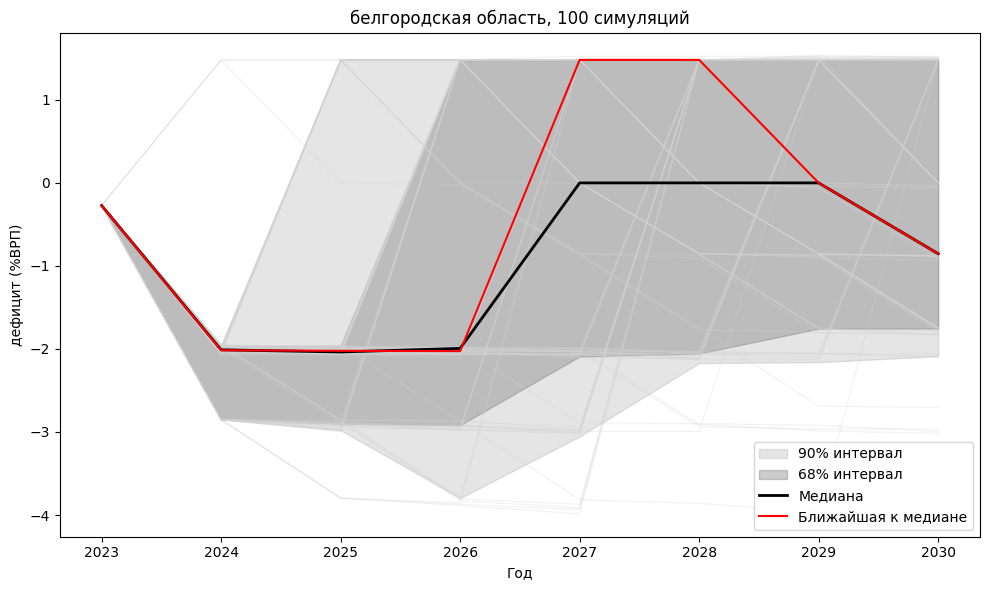

In [137]:
draw_plot(original_names[0], 'df', sims)

In [69]:
years_forecast = [i for i in range(2024, 2031)]
var_names = ['tc', 'te', 'df', 'pnd', 'tc_plan', 'te_plan']
# result of simulations
sims = {k:{i : pd.DataFrame(np.zeros(nsim*(len(years_forecast)+1)).reshape(nsim, len(years_forecast)+1),
             columns = [2023] + years_forecast) for i in var_names} for k in original_names}
# starting point
for k in original_names:
    reg_res = sims[k] # pull
    reg_res['tc'][2023] = [new_data.loc[k,'tc'].item()]*nsim
    reg_res['tc_plan'][2023] = [new_data.loc[k,'tc_plan'].item()]*nsim
    reg_res['te'][2023] = [new_data.loc[k,'te'].item()]*nsim
    reg_res['te_plan'][2023] = [new_data.loc[k,'te_plan'].item()]*nsim
    reg_res['df'][2023] = [new_data.loc[k,'df'].item()]*nsim
    reg_res['pnd'][2023] = [pdns.loc[k,'pdn'].item()]*nsim
    sims[k] = reg_res # push

In [88]:
sims['еврейская автономная область']['pnd']

,2023,2024,2025,2026,2027,2028,2029,2030
0,0.278658,0.284389,0.114913,-0.058561,-0.151067,-0.240324,-0.315596,-0.35195
1,0.278658,0.284389,0.114913,-0.058561,-0.151067,-0.240324,-0.315596,-0.35195
2,0.278658,0.284389,0.114913,-0.058561,-0.151067,-0.240324,-0.315596,-0.35195
3,0.278658,0.284389,0.114913,-0.058561,-0.151067,-0.240324,-0.315596,-0.35195
4,0.278658,0.284389,0.114913,-0.058561,-0.151067,-0.240324,-0.315596,-0.35195
...,...,...,...,...,...,...,...,...
95,0.278658,0.284389,0.114913,-0.058561,-0.151067,-0.240324,-0.315596,-0.35195
96,0.278658,0.284389,0.114913,-0.058561,-0.151067,-0.240324,-0.315596,-0.35195
97,0.278658,0.284389,0.114913,-0.058561,-0.151067,-0.240324,-0.315596,-0.35195
98,0.278658,0.284389,0.114913,-0.058561,-0.151067,-0.240324,-0.315596,-0.35195


In [91]:
model_te

Dep. Variable:,te,R-squared:,0.9195
Estimator:,PanelOLS,R-squared (Between):,0.9781
No. Observations:,425,R-squared (Within):,0.9297
Date:,"Mon, Oct 27 2025",R-squared (Overall):,0.9754
Time:,03:18:26,Log-likelihood,-384.62
Cov. Estimator:,Clustered,,
,,F-statistic:,214.21
Entities:,85,P-value,0.0000
Avg Obs:,5.0000,Distribution:,"F(17,319)"
Min Obs:,5.0000,,
Max Obs:,5.0000,F-statistic (robust):,92.435


In [ ]:
budget_forecast = {}
years_forecast = [i for i in range(2024, 2031)]
var_names = ['tc', 'te', 'df', 'pnd', 'tc_plan', 'te_plan']
sims = {k:{i : pd.DataFrame(np.zeros(nsim*(len(years_forecast)+1)).reshape(nsim, len(years_forecast)+1),
             columns = [2023] + years_forecast) for i in var_names} for k in original_names}

for k in original_names:
    reg_res = sims[k] # pull
    reg_res['tc'][2023] = [new_data.loc[k,'tc'].item()]*nsim
    reg_res['tc_plan'][2023] = [new_data.loc[k,'tc_plan'].item()]*nsim
    reg_res['te'][2023] = [new_data.loc[k,'te'].item()]*nsim
    reg_res['te_plan'][2023] = [new_data.loc[k,'te_plan'].item()]*nsim
    reg_res['df'][2023] = [new_data.loc[k,'df'].item()]*nsim
    reg_res['pnd'][2023] = [pdns.loc[k,'pdn'].item()]*nsim
    sims[k] = reg_res # push

    
    

In [56]:
pdns

,,pdn
region,year,
белгородская область,2023,0.141857
брянская область,2023,0.105355
владимирская область,2023,0.094459
воронежская область,2023,0.105602
ивановская область,2023,0.136125
...,...,...
амурская область,2023,0.232919
магаданская область,2023,0.283542
сахалинская область,2023,0.013995


In [55]:
new_data.columns

Index(['Доля дотаций в МБТ', 'Дефицит отношение', 'Рост ВРП',
       'Доля собственных доходов', 'Социальные расходы', 'Дефицит исполненный',
       'Дефицит планируемый', 'Константа', 'ДоИПР',
       'Изменение долговых расходов', 'Расходы на обслуживание долга',
       'Кластер', 'Кластер0', 'Кластер1', 'Кластер2', 'Кластер3',
       'Кластер0 рес', 'Кластер1 рес', 'Кластер2 рес', 'Кластер3 рес',
       'Кластер0 долг', 'Кластер1 долг', 'Кластер2 долг', 'Кластер3 долг',
       'Изменение дефицита', 'tc', 'te', 'tc_plan', 'te_plan', 'df', 'df_plan',
       'db', 'db_plan'],
      dtype='object')

In [50]:
reg_sim = [pd.DataFrame(np.zeros(nsim*(len(years_forecast)+1)).reshape(nsim, len(years_forecast)+1),
             columns = [2023] + years_forecast)]*6


In [41]:
3/8


0.375

In [43]:
new_data['tc_plan']

region                        year
белгородская область          2023     9.789979
брянская область              2023    40.932927
владимирская область          2023    35.179914
воронежская область           2023    26.859666
ивановская область            2023    48.903165
                                        ...    
амурская область              2023    19.014238
магаданская область           2023     9.337638
сахалинская область           2023    34.899241
еврейская автономная область  2023    36.095454
чукотский автономный округ    2023    33.858032
Name: tc_plan, Length: 85, dtype: object

In [34]:
test_data

,,Доля дотаций в МБТ,Дефицит отношение,Рост ВРП,Доля собственных доходов,Социальные расходы,Дефицит исполненный,Дефицит планируемый,Константа,ДоИПР,Изменение долговых расходов,...,Кластер3 долг,Изменение дефицита,tc,te,tc_plan,te_plan,df,df_plan,db,db_plan
region,year,,,,,,,,,,,,,,,,,,,,,
белгородская область,2023,0.335542,0.891685,1.061849,0.590858,0.649981,-0.271843,-1.950334,1,0.348040,-0.032104,...,0.000000,1.678491,16.860169,16.588326,18.006119,16.055785,-0.271843,-1.950334,0.065517,0.097621
брянская область,2023,0.323503,0.869930,1.072128,0.461148,0.633943,0.653264,-2.909432,1,0.004844,-0.004173,...,0.000000,3.562696,20.583466,21.23673,22.368267,19.458835,0.653264,-2.909432,0.029638,0.033811
владимирская область,2023,0.165337,0.903534,1.095468,0.605624,0.711187,0.279346,-1.665908,1,0.038455,-0.014391,...,0.000000,1.945254,16.330587,16.609932,17.269412,15.603503,0.279346,-1.665908,0.015407,0.029799
воронежская область,2023,0.105476,0.841973,1.060977,0.615848,0.672071,0.137937,-3.127338,1,0.026408,-0.000005,...,0.000000,3.265275,17.486631,17.624568,19.789935,16.662597,0.137937,-3.127338,0.010544,0.010549
ивановская область,2023,0.328143,0.917599,1.078671,0.448656,0.671536,0.486591,-1.884492,1,0.008650,-0.000724,...,0.000000,2.371083,21.707782,22.194373,22.869759,20.985267,0.486591,-1.884492,0.007231,0.007956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
амурская область,2023,0.096380,0.918716,1.077870,0.612231,0.595483,0.488570,-1.549849,1,0.576433,-0.030030,...,0.000000,2.038419,18.26875,18.75732,19.0671,17.517251,0.48857,-1.549849,0.119477,0.149507
магаданская область,2023,0.216002,0.983132,1.008638,0.432246,0.595928,-0.968461,-0.327643,1,2.071261,-0.007599,...,0.000000,-0.640818,18.592902,17.624441,19.423587,19.095944,-0.968461,-0.327643,0.154279,0.161879
сахалинская область,2023,0.003376,0.774718,1.160839,0.782576,0.493492,0.220798,-4.059085,1,0.292120,-0.005812,...,0.000000,4.279883,17.027611,17.248409,18.017761,13.958676,0.220798,-4.059085,0.03729,0.043102


In [284]:
(spendings.values).shape

(85, 1)

In [ ]:
shocks_tc[0,np.newaxis].T

(85, 1)

In [ ]:
# 2025
spendings, earnings = get_forecast(model_tc, test_data=new_data), get_forecast(model_te, test_data=new_data, tc=False)
deficit = (earnings-spendings)/earnings
pdns_new = pdns.values - deficit.values
reg_res_list = [] 
for i in range(spendings.shape[0]):
    
    reg_res_list.append((earnings.values[i].item(), spendings.values[i].item(), deficit.values[i].item(), pdns_new[i].item()))
pdns.loc[:,:] = pdns_new

#new data of plan components
new_data = test_data.copy(deep=True)
new_data.loc[:, ['tc_plan', 'te_plan']] = [get_new_es(i) for i in reg_res_list]
new_data['Дефицит планируемый'] = new_data['te_plan'] - new_data['tc_plan']
new_data['Дефицит отношение'] = new_data['te_plan']/new_data['tc_plan']

### Песочница

In [ ]:
from scipy import stats
for m in [(model1_fe, model1_re),
          (model3_fe, model3_re),
          (model5_fe, model5_re),
          (model7_fe, model7_re)
          ]:
    b_fe = m[0].params.values # type: ignore
    b_re = m[1].params.values # type: ignore
    V_fe = m[0].cov.values # type: ignore
    V_re = m[1].cov.values # type: ignore


    diff = b_fe - b_re # type: ignore
    V = V_fe - V_re

    try:
        stat = float(diff.T @ np.linalg.inv(V) @ diff)
        df_h = len(diff)
        pval = 1 - stats.chi2.cdf(stat, df_h) #type: ignore
        print(f"Hausman stat = {stat:.3f}, df = {df_h}, p = {pval:.4f}")
    except np.linalg.LinAlgError:
        print("Матрица (V_fe - V_re) необратима")

Hausman stat = 3.864, df = 7, p = 0.7953
Hausman stat = 159.813, df = 9, p = 0.0000
Hausman stat = -10.685, df = 6, p = 1.0000
Hausman stat = -8.240, df = 8, p = 1.0000


In [ ]:
def check_equal_clusters(x, n_years = 5):
    ari_matrix = np.zeros((n_years, n_years))
    for i in range(n_years):
        for j in range(i+1, n_years):
            ari = 0 if x[i] == x[j] else 1
            ari_matrix[i, j] = ari
            ari_matrix[j, i] = ari
    
    return ari_matrix[np.triu_indices(n_years, 1)].sum()
cluster_data = pd.DataFrame(cluster_column).T.set_axis(vrp.index, axis = 0).set_axis(list_of_years, axis = 1)
cluster_data['not_equal'] = [int(check_equal_clusters(cluster_data.loc[i].to_list()).item()) for i in vrp.index]
cluster_data = cluster_data.sort_values('not_equal').copy()
cluster_data['not_equal'] = ['Всегда в одном кластере' if i == 0 else 
                             "Один раз именяли кластер" if i == 4 else 
                             "Большую часть времени в одном кластере" if i in [6, 7] else 
                             "Не имеют кластеровой принадлежности" for i in cluster_data['not_equal']]

In [64]:
df.loc[:, ['Расходы на обслуживание долга', 'Кластер']].groupby('Кластер').agg({"Расходы на обслуживание долга":"mean"})

,Расходы на обслуживание долга
Кластер,
0,0.107270
1,0.157586
2,0.112015
3,0.122250
4,0.104962


Доля дотаций в МБТ  Дефицит отношение  \
region                     year                                          
белгородская область       2019            0.069876           0.934485   
                           2020            0.109277           0.932991   
                           2021            0.099364           1.109833   
                           2022            0.068490           0.804803   
                           2023            0.335542           0.891685   
...                                             ...                ...   
чукотский автономный округ 2019            0.334060           0.986916   
                           2020            0.577669           0.987378   
                           2021            0.556139           0.890232   
                           2022            0.544729           0.874682   
                           2023            0.533627           0.966426   

                                 Рост ВРП  Доля собственных доходов  \
region                     year                                       
белгородская область       2019  1.054232                  0.627457   
                           2020  1.044935                  0.568333   
                           2021  1.030415                  0.673187   
                           2022  1.124929                  0.604290   
                           2023  1.087354                  0.590858   
...                                   ...                       ...   
чукотский автономный округ 2019  1.049464                  0.215443   
                           2020  1.092387                  0.387937   
                           2021  1.128682                  0.329120   
                           2022  1.138072                  0.300246   
                           2023  1.065409                  0.342546   

                                 Социальные расходы  Дефицит исполненный  \
region                     year                                            
белгородская область       2019            0.628825            -0.090048   
                           2020            0.686004             0.016836   
                           2021            0.689167             2.422311   
                           2022            0.655199            -2.274987   
                           2023            0.649981            -0.271843   
...                                             ...                  ...   
чукотский автономный округ 2019            0.253758             0.396202   
                           2020            0.334768             3.711364   
                           2021            0.330224            -1.405542   
                           2022            0.362133            -3.462239   
                           2023            0.366073            -0.637730   

                                 Дефицит планируемый  Константа     ДоИПР  \
region                     year                                             
белгородская область       2019            -1.010103          1  0.148893   
                           2020            -1.069160          1  0.117556   
                           2021             1.482396          1  0.094571   
                           2022            -3.492084          1  0.333937   
                           2023            -1.950334          1  0.348040   
...                                              ...        ...       ...   
чукотский автономный округ 2019            -0.814737          1  2.525028   
                           2020            -0.573064          1  2.681575   
                           2021            -4.823418          1  2.221114   
                           2022            -5.501735          1  1.774252   
                           2023            -1.177462          1  1.908655   

                                 Изменение долговых расходов  ...  Кластер3  \
region                     year                               ...           

##### Кластеризация

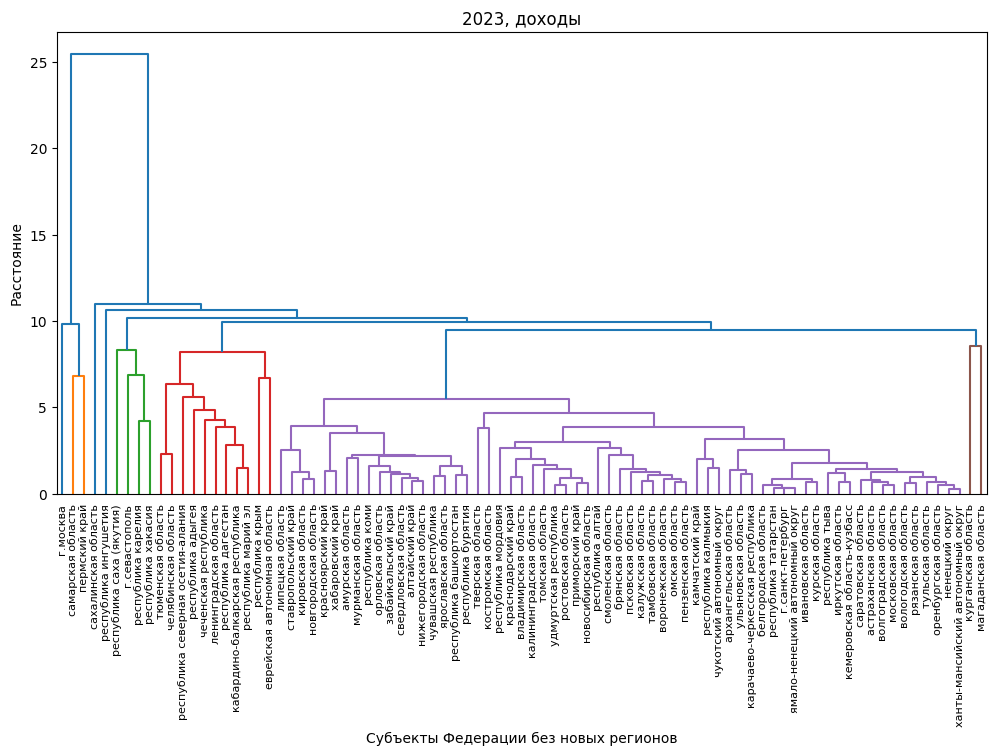

In [ ]:
year = str(2023)
df = pd.DataFrame(years[year]['earn'])
for code in earn_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    df.loc[name, :] /= 1000000*vrp.loc[name, year] # type: ignore

for code in earn_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: (x-df.loc[:, code].mean())/df.std()).round(5).copy()
    except:
        print(code)

# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, доходы")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

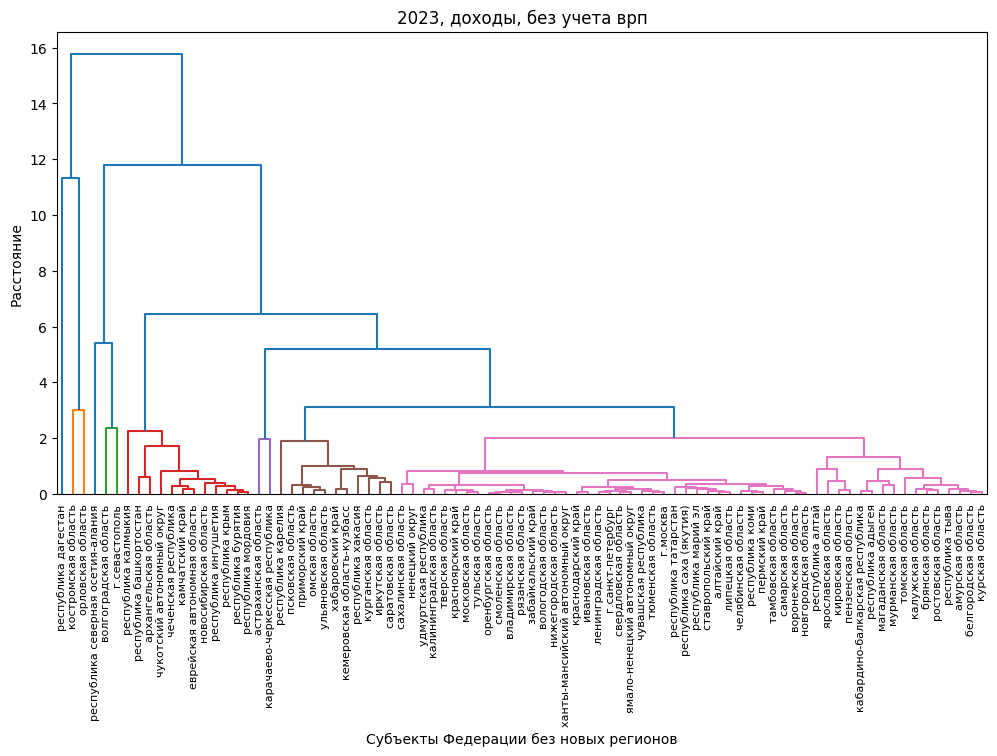

In [ ]:
year = str(2023)
df = pd.DataFrame(years[year]['earn'])
for code in earn_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    try:
        df.loc[name, :] = (df.loc[name, :]/df.loc[name, :].sum(0)).round().copy()
    except:
        print(name)
# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, доходы, без учета врп")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

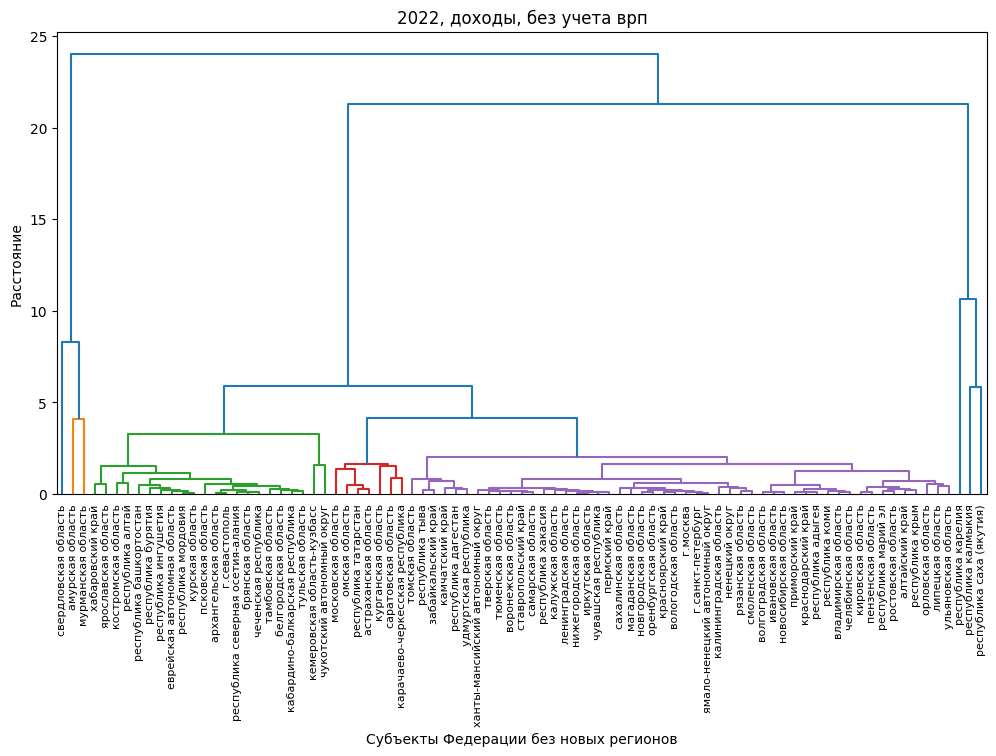

In [ ]:
year = str(2022)
df = pd.DataFrame(years[year]['earn'])
for code in earn_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    try:
        df.loc[name, :] = (df.loc[name, :]/df.loc[name, :].sum(0)).round().copy()
    except:
        print(name)
# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, доходы, без учета врп")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

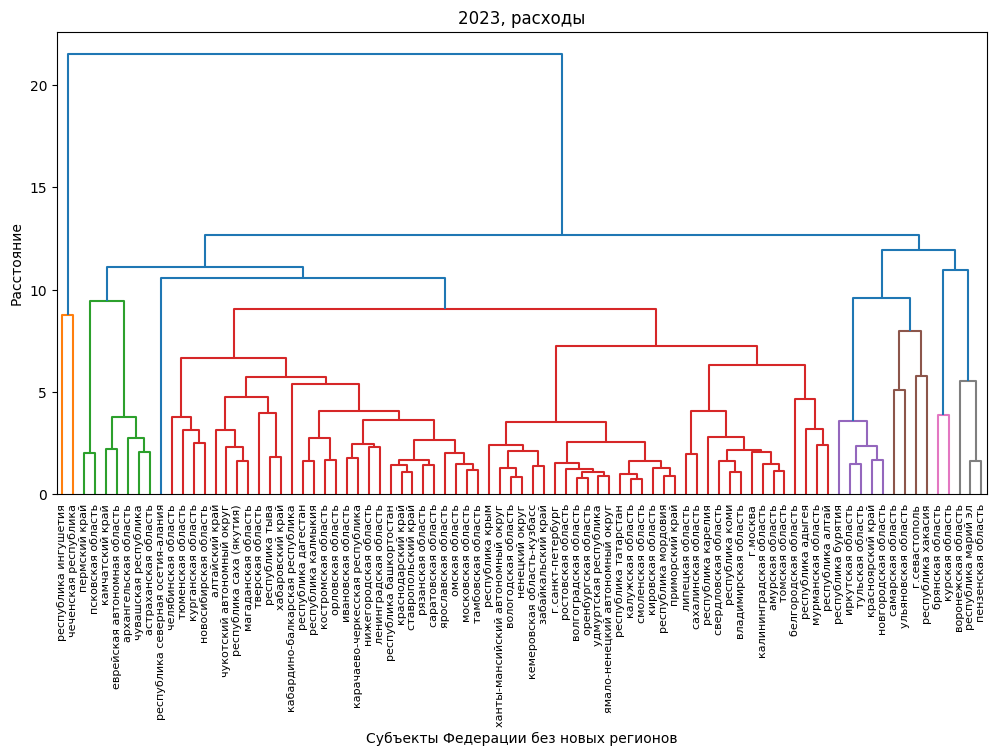

In [ ]:
year = str(2023)
df = pd.DataFrame(years[year]['cost'])
for code in cost_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    df.loc[name, :] /= 1000000*vrp.loc[name, year] # type: ignore

for code in cost_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: (x-df.loc[:, code].mean())/df.std()).round(5).copy()
    except:
        print(code)

# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, расходы")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

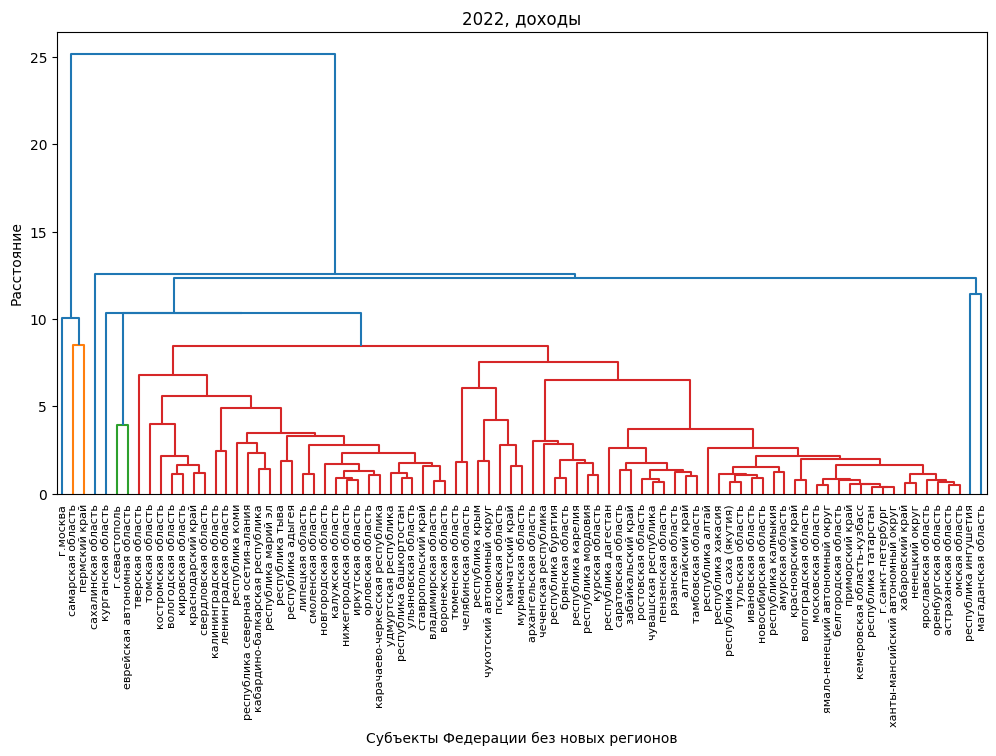

In [ ]:
year = str(2022)
df = pd.DataFrame(years[year]['earn'])
for code in earn_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    df.loc[name, :] /= 1000000*vrp.loc[name, year] # type: ignore

for code in earn_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: (x-df.loc[:, code].mean())/df.std()).round(5).copy()
    except:
        print(code)

# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, доходы")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

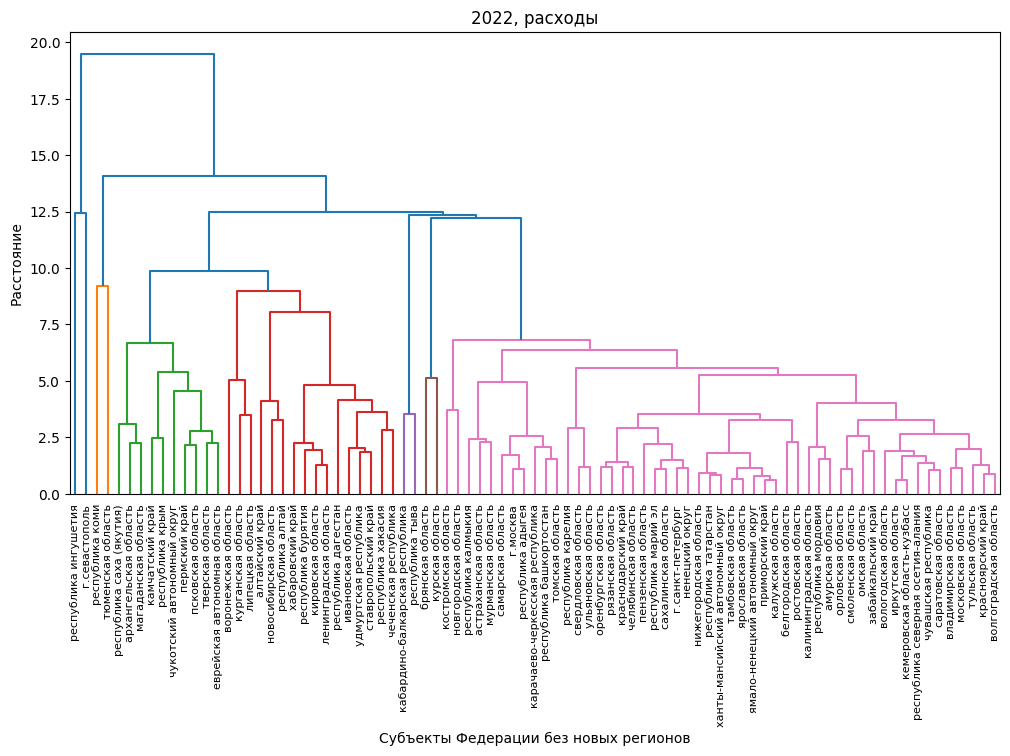

In [ ]:
year = str(2022)
df = pd.DataFrame(years[year]['cost'])
for code in cost_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    df.loc[name, :] /= 1000000*vrp.loc[name, year] # type: ignore

for code in cost_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: (x-df.loc[:, code].mean())/df.std()).round(5).copy()
    except:
        print(code)

# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, расходы")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

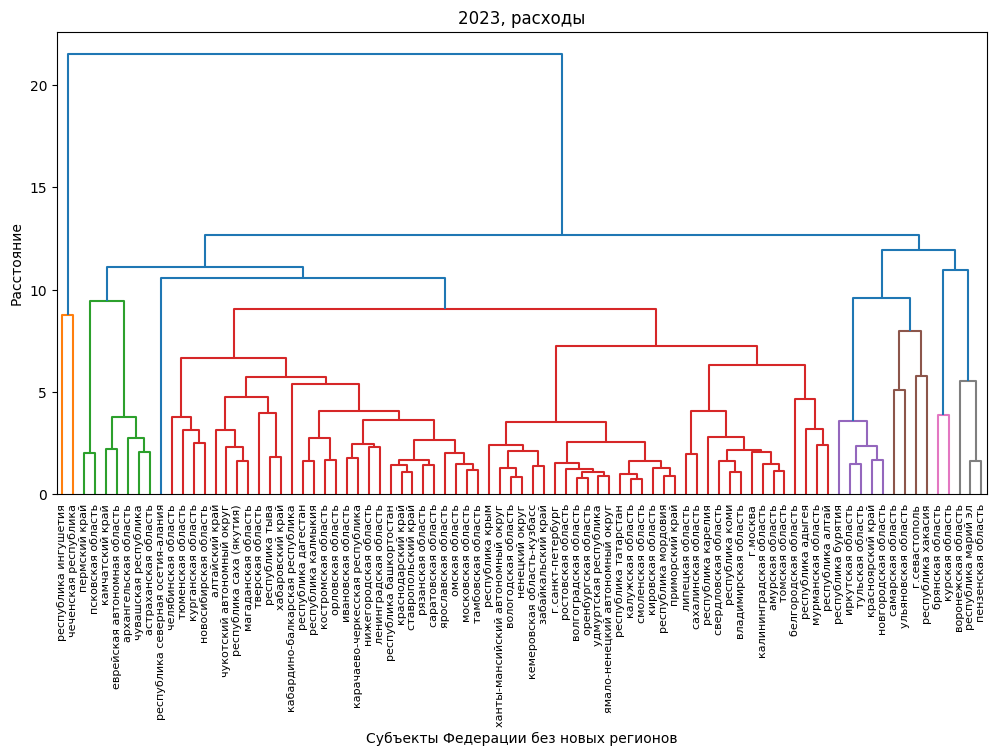

In [ ]:
year = str(2023)
df = pd.DataFrame(years[year]['cost'])
for code in cost_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: x['Исполнено'] - x['Утверждено']).round().copy()
    except:
        print(code)

df = df.set_index('name')
for name in original_names:
    df.loc[name, :] /= 1000000*vrp.loc[name, year] # type: ignore

for code in cost_list:
    try:
        df.loc[:, code] = df.loc[:, code].apply(lambda x: (x-df.loc[:, code].mean())/df.std()).round(5).copy()
    except:
        print(code)

# Кластеризация
Z = linkage(df.values, method="ward")

# Рисуем дендрограмму с подписями
plt.figure(figsize=(12, 6))
dendrogram(
    Z,
    labels=df.index.astype(str),  
    leaf_rotation=90,             
    leaf_font_size=8,
    color_threshold=Z[-7, 2]              
)
plt.title(f"{year}, расходы")
plt.xlabel("Субъекты Федерации без новых регионов")
plt.ylabel("Расстояние")
plt.show()

In [ ]:
df

,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300
name,,,,,,,,,,,,,
республика башкортостан,0.64105,0.23429,0.3976,-0.11333,0.63255,0.54078,0.48088,0.43678,0.078,0.46495,-0.62055,0.25923,0.35284
республика бурятия,0.24187,0.23274,-0.58109,0.54656,-0.20993,-3.85189,0.33651,0.46114,0.03101,-1.67692,0.39076,0.15707,-0.52538
республика дагестан,0.33839,0.23256,-0.27564,0.81004,-0.12393,0.86503,-1.26777,0.176,-0.53991,0.48504,0.1445,-0.71373,0.50083
кабардино-балкарская республика,0.47792,-0.11182,0.43378,-1.06518,1.09148,0.816,0.04964,0.21656,0.30154,-0.10897,0.39448,-3.57601,0.52484
республика калмыкия,0.39556,0.04986,0.08904,0.19484,0.40248,0.50812,-1.37365,0.3158,0.21496,0.40047,-0.31408,0.15763,0.52469
...,...,...,...,...,...,...,...,...,...,...,...,...,...
ханты-мансийский автономный округ,0.64629,0.23408,0.3804,1.31531,1.05436,-1.08273,0.62435,0.5722,0.69865,0.58214,0.03654,-0.01985,0.48257
чукотский автономный округ,0.27057,0.23282,0.14383,0.1476,-1.1032,0.51162,0.02568,-1.94271,0.18967,0.3265,0.21939,0.32581,0.52095
ямало-ненецкий автономный округ,0.49931,0.23256,-0.02033,0.25302,0.94806,0.69012,0.74283,0.65813,0.84519,0.48499,0.39161,0.31711,0.52485
